In [29]:
import glob
futureList = glob.glob('C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet/*.parquet')
print(futureList)

import pandas as pd

df_fut = pd.read_parquet(futureList[0])

for future_file in futureList[1:]:
    df_future = pd.read_parquet(future_file)
    
    df_fut = pd.concat([df_fut, df_future], axis=0, ignore_index=True)


# 檢查結果
# print(df_opt.info())
print(df_fut.columns)


df_opt = pd.read_parquet("C:/my_file/0_research/20250908_FutureStrategy/option_data/processed_parquet/opt_all.parquet")
df_opt = df_opt.drop(columns=['漲跌價', '漲跌%', 'Unnamed: 20', '契約到期日', 'Unnamed: 21'])
print(df_opt.columns)



['C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2001_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2002_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2003_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2004_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2005_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2006_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2007_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2008_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2009_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2010_fut.parquet', 'C:/my_file/0_research/202509

In [30]:
import pandas as pd
import numpy as np

def clean_numeric_col(series):
    """
    輔助函式：清洗含有逗號的數字字串，並處理 '-' 為 NaN
    """
    return pd.to_numeric(
        series.astype(str).str.replace(',', '').str.strip().replace('-', np.nan), 
        errors='coerce'
    )

def clean_futures_data(df_raw):
    """
    清洗期貨資料
    1. 轉換日期格式
    2. 排除價差單 (含有 '/' 的合約)
    3. 轉換價格欄位為浮點數
    """
    print("--- 開始清洗期貨資料 (Futures) ---")
    df = df_raw.copy()
    
    # 1. 日期標準化
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    
    # 2. 排除價差單 (Spread Orders)
    # 檢查 '到期月份(週別)' 和 '契約' 是否含有 '/'
    mask_spread_month = df['到期月份(週別)'].astype(str).str.contains('/')
    mask_spread_contract = df['契約'].astype(str).str.contains('/')
    
    before_len = len(df)
    df = df[~(mask_spread_month | mask_spread_contract)]
    after_len = len(df)
    print(f">> 已排除價差單: {before_len - after_len} 筆")

    # 3. 數值欄位清洗 (去除逗號, 轉 float)
    target_cols = ['開盤價', '最高價', '最低價', '收盤價', '結算價']
    for col in target_cols:
        if col in df.columns:
            df[col] = clean_numeric_col(df[col])
            
    # 4. 排序與重設索引
    df.sort_values(by=['交易日期', '契約', '到期月份(週別)'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print(f">> 期貨資料清洗完成，共 {len(df)} 筆。")
    return df

def clean_options_data(df_raw):
    """
    清洗選擇權資料
    1. 過濾非一般交易時段
    2. 轉換日期與履約價格式
    3. 轉換價格欄位
    """
    print("--- 開始清洗選擇權資料 (Options) ---")
    df = df_raw.copy()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()
    
    # 1. 過濾交易時段 (只留 '一般')
    if '交易時段' in df.columns:
        before_len = len(df)
        df = df[df['交易時段'] == '一般']
        print(f">> 已過濾盤後資料: {before_len - len(df)} 筆")
    
    # 2. 日期標準化
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    
    # 3. 履約價轉數值 (重要：用於排序與查找)
    df['履約價'] = clean_numeric_col(df['履約價'])
    
    # 4. 價格欄位清洗
    target_cols = ['開盤價', '最高價', '最低價', '收盤價', '結算價']
    for col in target_cols:
        if col in df.columns:
            df[col] = clean_numeric_col(df[col])
            
    # 5. 確保到期月份格式乾淨 (去除空格)
    df['到期月份(週別)'] = df['到期月份(週別)'].astype(str).str.strip()

    # 6. 排序
    # 注意：履約價排序對於尋找價差組合(Spread)很重要
    df.sort_values(by=['交易日期', '到期月份(週別)', '履約價'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print(f">> 選擇權資料清洗完成，共 {len(df)} 筆。")
    return df

# ==========================================
# 執行清洗 (假設 df_fut 和 df_opt 已經讀入)
# ==========================================
# 為了避免變數名稱衝突，建議使用 _clean 後綴
df_fut_clean = clean_futures_data(df_fut)
df_opt_clean = clean_options_data(df_opt)

# 簡單檢查一下結果
print("\n[檢查] 期貨資料前 3 筆:")
print(df_fut_clean[['交易日期', '契約', '到期月份(週別)', '開盤價', '收盤價']].head(3))

print("\n[檢查] 選擇權資料前 3 筆:")
print(df_opt_clean[['交易日期', '到期月份(週別)', '履約價', '買賣權', '收盤價']].head(3))

--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 36798 筆
>> 期貨資料清洗完成，共 44990 筆。
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 2317932 筆
>> 選擇權資料清洗完成，共 1529628 筆。

[檢查] 期貨資料前 3 筆:
        交易日期  契約 到期月份(週別)     開盤價     收盤價
0 2001-01-02  TX   200101  4702.0  4892.0
1 2001-01-02  TX   200102  4750.0  4909.0
2 2001-01-02  TX   200103  4724.0  4950.0

[檢查] 選擇權資料前 3 筆:
        交易日期 到期月份(週別)     履約價 買賣權  收盤價
0 2017-01-03   201701  7500.0  買權  0.0
1 2017-01-03   201701  7500.0  賣權  0.1
2 2017-01-03   201701  7600.0  買權  0.0


In [3]:
df_fut_clean

,交易日期,契約,到期月份(週別),開盤價,最高價,最低價,收盤價,漲跌價,漲跌%,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段,價差對單式委託成交量
0,2001-01-02,TX,200101,4702.0,4948.0,4685.0,4892.0,122,2.56%,14824,4892.0,6699,4892.0,4893.0,5612,4561,NaN,NaN,NaN
1,2001-01-02,TX,200102,4750.0,4948.0,4666.0,4909.0,174,3.67%,102,4909.0,129,4890.0,4910.0,4948,4570,NaN,NaN,NaN
2,2001-01-02,TX,200103,4724.0,4950.0,4724.0,4950.0,112,2.32%,4,4919.0,34,4808.0,5030.0,9500,4635,NaN,NaN,NaN
3,2001-01-02,TX,200106,5030.0,5030.0,4900.0,4901.0,153,3.22%,4,4901.0,21,4900.0,4977.0,8700,4680,NaN,NaN,NaN
4,2001-01-02,TX,200109,0.0,0.0,0.0,0.0,-,-,0,4988.0,0,0.0,0.0,4953,4780,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44985,2026-01-16,TX,202606,31470.0,31700.0,31462.0,31700.0,355,1.13%,45,0.0,0,31550.0,31641.0,31700,20819,None,盤後,None
44986,2026-01-16,TX,202609,31400.0,31560.0,31273.0,31514.0,370,1.19%,15,31527.0,200,31510.0,31544.0,31560,24962,None,一般,None
44987,2026-01-16,TX,202609,31294.0,31500.0,31260.0,31500.0,356,1.14%,14,0.0,0,31323.0,31436.0,31500,24962,None,盤後,None
44988,2026-01-16,TX,202612,31502.0,31670.0,31370.0,31615.0,353,1.13%,12,31634.0,66,31609.0,31659.0,31670,27382,None,一般,None


In [31]:
import pandas as pd
import numpy as np

def get_target_contract_price(df_fut_clean, date, contract_month):
    """
    取得特定日期、特定合約月份的期貨價格。
    
    參數:
        df_fut_clean (pd.DataFrame): 經過 clean_futures_data 清洗後的期貨資料表。
        date (pd.Timestamp or str): 查詢日期。
        contract_month (str): 目標合約月份 (e.g., '202205')。
        
    回傳:
        float: 該合約當日的價格 (優先順序: 開盤價 > 收盤價 > 結算價)。
        None: 若查無資料。
    """
    
    # 1. 確保日期格式一致
    target_date = pd.to_datetime(date)
    
    # 2. 確保合約月份格式一致 (去除空白, 轉字串)
    target_month = str(contract_month).strip()
    
    # 3. 篩選日期 (利用 Boolean Mask)
    # 註：若資料量極大，可考慮將交易日期設為 Index 以加速，但此處維持通用性
    day_data = df_fut_clean[df_fut_clean['交易日期'] == target_date].copy()
    
    if day_data.empty:
        print(f">> 查無 {target_date.date()} 的期貨資料。")
        return None
        
    # 4. 篩選合約月份
    day_data['到期月份(週別)'] = day_data['到期月份(週別)'].str.strip()
    contract_data = day_data[day_data['到期月份(週別)'] == target_month]
    del day_data  # 釋放記憶體
    
    if contract_data.empty:
        print(f">> 查無 {target_date.date()} 的 {target_month} 合約資料。")
        return None
        
    # 5. 取得第一筆資料 (理論上清洗後同一天同一合約只會有一筆)
    row = contract_data.iloc[0]
    
    # 6. 價格選取邏輯 (Open > Close > Settlement)
    price = np.nan
    
    # 嘗試取得開盤價
    if '開盤價' in row and pd.notna(row['開盤價']) and row['開盤價'] > 0:
        price = row['開盤價']
    # Fallback: 收盤價
    elif '收盤價' in row and pd.notna(row['收盤價']) and row['收盤價'] > 0:
        price = row['收盤價']
    # Fallback: 結算價 (處理無成交量但有結算價的情況)
    elif '結算價' in row and pd.notna(row['結算價']) and row['結算價'] > 0:
        price = row['結算價']
        
    # 7. 回傳結果
    if pd.isna(price) or price <= 0:
        print(f">> {target_date.date()} 的 {target_month} 合約無有效價格資料。")
        return None
    
    return float(price)

# ==========================================
# 測試範例
# ==========================================
# 假設 df_fut_clean 已經存在
target_date = pd.Timestamp('2020-11-17')
contract = '202101'
price = get_target_contract_price(df_fut_clean, target_date, contract)
print(f"日期: {target_date.date()}, 合約: {contract}, 價格: {price}")

日期: 2020-11-17, 合約: 202101, 價格: 13531.0


In [32]:
import pandas as pd
import numpy as np


from datetime import datetime, timedelta
def weekday_count(y,m,weekday="Wed",count=3):
    weekday_map = {"Mon":0, "Tue":1, "Wed":2, "Thu":3, "Fri":4, "Sat":5, "Sun":6}
    target_weekday = weekday_map.get(weekday, 2)  # Default to Wednesday if not found
    first_day = datetime(y, m, 1)
    weekday_count = 0
    temp = first_day
    while weekday_count < count:
        if temp.weekday() == target_weekday:
            weekday_count += 1
        if weekday_count < count:
            temp += timedelta(days=1)
    return temp
    
def get_expiry_date(contract_str):
    try:
        s = str(contract_str).split('.')[0].strip()

        y = int(s[:4])
        m = int(s[4:6])
        if len(s) > 6: 
            weekSymbol = s[6]
            count = int(s[7])
            if weekSymbol in ['W','w']:
                return weekday_count(y, m, "Wed", count)
            elif weekSymbol in ['F','f']:
                return weekday_count(y, m, "Fri", count)
            else:
                return pd.NaT
        return weekday_count(y, m, "Wed", 3)
    except:
        return pd.NaT
import numpy as np
import pandas as pd
import py_lets_be_rational as lj

def get_greeks(df_opt, nowDate, S, R):
    now_df = df_opt[df_opt['交易日期'] == nowDate]
    call_df = now_df[now_df['買賣權']=='買權']
    put_df  = now_df[now_df['買賣權']=='賣權']
    
    
    """
    1. 先計算 Implied Volatility (IV)
    2. 再使用 IV 計算 Greeks
    """
    # 避免 SettingWithCopyWarning
    call_df = call_df.copy()
    put_df = put_df.copy()

    # ==========================================
    # 1. 時間前處理 (T & dT)
    # ==========================================
    # 假設 get_expiry_date 函式已定義
    call_df['T'] = call_df['到期月份(週別)'].apply(get_expiry_date)
    put_df['T'] = put_df['到期月份(週別)'].apply(get_expiry_date)

    # 計算年化剩餘時間，並設定極小值避免除以零
    call_df['dT'] = ((call_df['T'] - call_df['交易日期']).dt.days / 365.0).clip(lower=1e-5)
    put_df['dT'] = ((put_df['T'] - put_df['交易日期']).dt.days / 365.0).clip(lower=1e-5)

    # ==========================================
    # 2. 定義 IV 計算函式
    # ==========================================
    def calculate_iv(row, option_type_flag):
        """
        option_type_flag: 1.0 for Call, -1.0 for Put
        """
        price = row['收盤價']
        K = row['履約價']
        T = row['dT']
        
        # 簡易檢查：價格異常或時間歸零直接回傳 0
        if price <= 0 or T <= 0:
            return 0.0

        # 計算遠期價格 F = S * exp(R*T)
        F = S * np.exp(R * T)

        # 檢查內含價值 (Intrinsic Value) 防止套利違規導致錯誤
        intrinsic = max(0, F - K) if option_type_flag == 1 else max(0, K - F)
        if price <= intrinsic:
            return 0.0  # 價格低於內含價值，理論上 IV 為 0 或無解

        try:
            # 使用 py_lets_be_rational 反推 IV
            # 參數順序: price, F, K, T, q
            iv = lj.implied_volatility_from_a_transformed_rational_guess(
                price, F, K, T, option_type_flag
            )
            return iv
        except:
            return 0.0

    # ==========================================
    # 3. 執行 IV 計算
    # ==========================================
    # Call: q = 1.0
    call_df['Implied_Volatility'] = call_df.apply(lambda row: calculate_iv(row, 1.0), axis=1)
    
    # Put: q = -1.0
    put_df['Implied_Volatility'] = put_df.apply(lambda row: calculate_iv(row, -1.0), axis=1)

    # ==========================================
    # 4. 定義 Greeks 計算函式 (Black-Scholes)
    # ==========================================
    def calculate_bs_greeks(row, option_type_str):
        K = row['履約價']
        T = row['dT']
        sigma = row['Implied_Volatility']
        
        if sigma <= 0 or T <= 0:
            return 0.0, 0.0, 0.0, 0.0, 0.0
            
        sqrt_T = np.sqrt(T)
        d1 = (np.log(S / K) + (R + 0.5 * sigma ** 2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T

        # 使用 lj.norm_cdf
        nd1 = lj.norm_cdf(d1)
        nd2 = lj.norm_cdf(d2)
        n_prime_d1 = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * d1 ** 2)

        # Delta, Itm Probability
        if option_type_str == 'call':
            delta = nd1
            itm_prob = nd2
        else:
            delta = nd1 - 1.0
            itm_prob = 1.0 - nd2
        # Gamma
        gamma = n_prime_d1 / (S * sigma * sqrt_T)

        # Vega
        vega = S * sqrt_T * n_prime_d1

        # Theta
        theta_common = -(S * sigma * n_prime_d1) / (2 * sqrt_T)
        if option_type_str == 'call':
            theta = theta_common - R * K * np.exp(-R * T) * nd2
        else:
            n_neg_d2 = 1.0 - nd2
            theta = theta_common + R * K * np.exp(-R * T) * n_neg_d2
            
        return delta, gamma, theta, vega, itm_prob

    # ==========================================
    # 5. 執行 Greeks 計算
    # ==========================================
    # Call Greeks
    greeks_call = call_df.apply(lambda row: calculate_bs_greeks(row, 'call'), axis=1, result_type='expand')
    call_df[['Delta', 'Gamma', 'Theta', 'Vega', 'Itm_Prob']] = greeks_call

    # Put Greeks
    greeks_put = put_df.apply(lambda row: calculate_bs_greeks(row, 'put'), axis=1, result_type='expand')
    put_df[['Delta', 'Gamma', 'Theta', 'Vega', 'Itm_Prob']] = greeks_put
    
    return call_df, put_df



def market_data_generator(start_date, end_date, df_opt, df_fut, risk_free_rate=0.01):
    """
    逐日生成市場資料生成器 (Generator)
    
    Yields:
        tuple: (current_date, S, call_df, put_df)
        
        - current_date (pd.Timestamp): 當前交易日
        - S (float): 當日標的價格 (使用近月期貨價格)
        - call_df (pd.DataFrame): 當日 Call 資料表 (含 Greeks)
        - put_df (pd.DataFrame): 當日 Put 資料表 (含 Greeks)
    """
    
    print(f"--- 初始化市場資料生成器 ({start_date} to {end_date}) ---")
    
    # 1. 建立交易日曆 (只取期貨有資料的日子，並限制在回測區間內)
    # 確保 index 重設，方便後續操作
    all_dates = df_fut['交易日期'].unique()
    # all_dates = pd.to_datetime(all_dates).sort_values()
    all_dates = all_dates[pd.to_datetime(all_dates).argsort()]
    # all_dates = pd.DataFrame(all_dates).sort_values(by=0)[0]
    
    mask_date = (all_dates >= pd.to_datetime(start_date)) & (all_dates <= pd.to_datetime(end_date))
    trade_dates = all_dates[mask_date]
    
    print(f">> 預計執行交易日數: {len(trade_dates)} 天")

    # 2. 逐日迴圈
    for current_date in trade_dates:
        
        # ==========================================
        # A. 取得當日標的價格 S (Near Month Future)
        # ==========================================
        # 篩選當日期貨資料
        daily_fut = df_fut[df_fut['交易日期'] == current_date]
        
        if daily_fut.empty:
            continue
            
        # 找出「近月合約」：排序「到期月份」，取第一筆
        # 假設資料已清洗過，無價差單，且格式正確
        daily_fut_sorted = daily_fut.sort_values(by='到期月份(週別)')
        
        # 取最近月合約
        near_month_row = daily_fut_sorted.iloc[0]
        
        # 決定價格 (Open > Close > Settlement)
        S = near_month_row['開盤價']
        if pd.isna(S) or S <= 0:
            S = near_month_row['收盤價']
        if pd.isna(S) or S <= 0:
            S = near_month_row['結算價']
            
        # 若仍無價格，跳過該日
        if pd.isna(S) or S <= 0:
            # print(f"Warning: {current_date.date()} 查無有效標的價格 S，跳過。")
            continue

        # ==========================================
        # B. 準備當日選擇權資料
        # ==========================================
        # 為了效能，先從大表切出當日資料
        daily_opt = df_opt[df_opt['交易日期'] == current_date]
        
        if daily_opt.empty:
            continue

        # ==========================================
        # C. 計算 Greeks
        # ==========================================
        # 呼叫您提供的 get_greeks 函式
        # 注意：get_greeks 會回傳 (call_df, put_df)
        try:
            # 這裡傳入 daily_opt，get_greeks 內部會再 filter 一次 date，這沒問題
            call_greeks, put_greeks = get_greeks(daily_opt, current_date, S, risk_free_rate)
            
            # 簡單防呆：確保回傳不是空的
            if call_greeks.empty and put_greeks.empty:
                continue
                
            # ==========================================
            # D. Yield 結果
            # ==========================================
            yield current_date, S, call_greeks, put_greeks
            
        except Exception as e:
            print(f"Error on {current_date.date()}: {e}")
            continue

print(">> Generator 函式定義完成。")

>> Generator 函式定義完成。


In [6]:
# ==========================================
# Generator 測試腳本
# ==========================================

# 1. 設定測試區間 (跑個幾天就好)
TEST_START = '2002-01-01'  # 請確保您的資料包含這段時間
TEST_END   = '2022-01-15'

print(f"--- 開始測試 Generator: {TEST_START} ~ {TEST_END} ---\n")

# 2. 初始化 Generator
# 注意：這裡傳入的是已經清洗過的 df_opt_clean 與 df_fut_clean
gen = market_data_generator(
    start_date=TEST_START, 
    end_date=TEST_END, 
    df_opt=df_opt_clean, 
    df_fut=df_fut_clean, 
    risk_free_rate=0.01
)

# 3. 執行並觀察輸出
try:
    count = 0
    for date, S, calls, puts in gen:
        count += 1
        print(f"[{count}] 日期: {date.date()} | 標的價格 S: {S}")
        print(f"    > Call 數量: {len(calls)}, Put 數量: {len(puts)}")
        
        # 檢查 Greeks 是否計算成功 (檢查 Delta 是否存在且不全為 0)
        # 隨機抽樣看一筆價平附近的資料 (假設 S=18000, 找 18000 附近的)
        if not calls.empty:
            # 找最接近 S 的履約價
            nearest_idx = (calls['履約價'] - S).abs().idxmin()
            sample_call = calls.loc[nearest_idx]
            
            print(f"    > [檢查] 履約價 {sample_call['履約價']} Call:")
            print(f"      IV    : {sample_call['Implied_Volatility']:.4f}")
            print(f"      Delta : {sample_call['Delta']:.4f}")
            print(f"      Vega  : {sample_call['Vega']:.4f}")
            
            if sample_call['Implied_Volatility'] == 0:
                print("      [警示] IV 為 0，可能是資料異常或該履約價無成交。")
        
        print("-" * 30)
        
        # 只測前 3 天就停，節省時間
        if count >= 10:
            print(">> 測試結束：前 3 天資料讀取成功。")
            break
            
except Exception as e:
    print(f"\n[錯誤] Generator 執行失敗: {e}")
    import traceback
    traceback.print_exc()

--- 開始測試 Generator: 2002-01-01 ~ 2022-01-15 ---

--- 初始化市場資料生成器 (2002-01-01 to 2022-01-15) ---
>> 預計執行交易日數: 4953 天
[1] 日期: 2017-01-03 | 標的價格 S: 9266.0
    > Call 數量: 166, Put 數量: 166
    > [檢查] 履約價 9250.0 Call:
      IV    : 0.2114
      Delta : 0.5652
      Vega  : 190.8971
------------------------------
[2] 日期: 2017-01-04 | 標的價格 S: 9281.0
    > Call 數量: 188, Put 數量: 188
    > [檢查] 履約價 9300.0 Call:
      IV    : 0.0957
      Delta : 0.4684
      Vega  : 722.8631
------------------------------
[3] 日期: 2017-01-05 | 標的價格 S: 9270.0
    > Call 數量: 163, Put 數量: 163
    > [檢查] 履約價 9250.0 Call:
      IV    : 0.2151
      Delta : 0.5391
      Vega  : 471.8788
------------------------------
[4] 日期: 2017-01-06 | 標的價格 S: 9353.0
    > Call 數量: 165, Put 數量: 165
    > [檢查] 履約價 9350.0 Call:
      IV    : 0.1118
      Delta : 0.5166
      Vega  : 436.3402
------------------------------
[5] 日期: 2017-01-09 | 標的價格 S: 9379.0
    > Call 數量: 166, Put 數量: 166
    > [檢查] 履約價 9400.0 Call:
      IV    : 0.0760


In [7]:
now_data = next(gen)  # 呼叫 next() 以取得下一筆資料
now_data

(Timestamp('2017-01-17 00:00:00'),
 9282.0,
            交易日期   契約 到期月份(週別)      履約價 買賣權   開盤價   最高價   最低價   收盤價  成交量  ...  \
 3262 2017-01-17  TXO   201701   7500.0  買權   0.0   0.0   0.0   0.0    0  ...   
 3264 2017-01-17  TXO   201701   7600.0  買權   0.0   0.0   0.0   0.0    0  ...   
 3266 2017-01-17  TXO   201701   7700.0  買權   0.0   0.0   0.0   0.0    0  ...   
 3268 2017-01-17  TXO   201701   7800.0  買權   0.0   0.0   0.0   0.0    0  ...   
 3270 2017-01-17  TXO   201701   7900.0  買權   0.0   0.0   0.0   0.0    0  ...   
 ...         ...  ...      ...      ...  ..   ...   ...   ...   ...  ...  ...   
 3552 2017-01-17  TXO   201709  10000.0  買權  60.0  71.0  60.0  69.0  336  ...   
 3554 2017-01-17  TXO   201709  10400.0  買權  24.0  30.0  24.0  28.5  182  ...   
 3556 2017-01-17  TXO   201709  10800.0  買權   9.8  13.0   9.8  13.0   85  ...   
 3558 2017-01-17  TXO   201709  11200.0  買權   4.4   5.5   4.4   5.5   25  ...   
 3560 2017-01-17  TXO   201709  11600.0  買權   0.0   0.0   0.0   0

In [8]:
now_data[2].columns

Index(['交易日期', '契約', '到期月份(週別)', '履約價', '買賣權', '開盤價', '最高價', '最低價', '收盤價',
       '成交量', '結算價', '未沖銷契約數', '最後最佳買價', '最後最佳賣價', '歷史最高價', '歷史最低價',
       '是否因訊息面暫停交易', '交易時段', 'T', 'dT', 'Implied_Volatility', 'Delta', 'Gamma',
       'Theta', 'Vega', 'Itm_Prob'],
      dtype='object')

In [33]:
import pandas as pd
from datetime import datetime, timedelta

# ==========================================
# 1. 輔助函式：月份運算
# ==========================================
def get_next_month_str(ym_str):
    """
    輸入 '202201' -> 回傳 '202202'
    輸入 '202212' -> 回傳 '202301'
    """
    y = int(ym_str[:4])
    m = int(ym_str[4:6])
    
    if m == 12:
        next_y = y + 1
        next_m = 1
    else:
        next_y = y
        next_m = m + 1
        
    return f"{next_y:04d}{next_m:02d}"

# ==========================================
# 2. 核心：建立換倉地圖
# ==========================================
def build_rollover_map(df_fut_clean, start_date, end_date, offset=3):
    """
    建立換倉日對照表
    
    Returns:
        dict: { 
            pd.Timestamp('2022-01-17'): {'close': '202201', 'open': '202202'},
            ...
        }
    """
    print(f"--- 建立換倉日曆 (Offset={offset}) ---")
    
    # 1. 取得所有有效的交易日清單 (Sorted List)
    all_dates = sorted(df_fut_clean['交易日期'].unique())
    all_dates_pd = pd.to_datetime(all_dates)
    
    rollover_map = {}
    
    # 2. 產生需要計算的月份清單
    # 為了保險，我們從 start_date 的前一個月開始抓，一直抓到 end_date 後一個月
    s_dt = pd.to_datetime(start_date)
    e_dt = pd.to_datetime(end_date)
    
    # 產生月份區間
    # 這裡用一個簡單的迴圈來跑年份跟月份
    current_y, current_m = s_dt.year, s_dt.month
    end_y, end_m = e_dt.year, e_dt.month
    
    # 調整起始月份往前一點，以免漏掉第一筆
    if current_m == 1:
        current_y -= 1
        current_m = 12
    else:
        current_m -= 1
        
    months_to_process = []
    while (current_y < end_y) or (current_y == end_y and current_m <= end_m):
        months_to_process.append(f"{current_y:04d}{current_m:02d}")
        
        if current_m == 12:
            current_y += 1
            current_m = 1
        else:
            current_m += 1
    
    # 3. 針對每個月計算結算日與換倉日
    for ym in months_to_process:
        y = int(ym[:4])
        m = int(ym[4:6])
        
        # A. 計算理論結算日 (第3個週三)
        # 注意：weekday_count 需要您原本提供的函式
        try:
            theoretical_expiry = weekday_count(y, m, "Wed", 3)
        except:
            continue
            
        # B. 在實際交易日曆中找到這個日期 (或最接近的日期)
        # 使用 searchsorted 尋找插入點
        # all_dates_pd 是排序過的 Timestamp 陣列
        idx = all_dates_pd.searchsorted(theoretical_expiry)
        
        # 防呆：若超出範圍
        if idx >= len(all_dates_pd):
            continue
            
        # 這裡假設結算日就是 idx 指向的那一天 (通常是週三，若遇假日會自動往後延到下一個交易日)
        expiry_idx = idx
        
        # C. 計算換倉日 (往回推 Offset - 1 天)
        # 例如 Offset=3 (倒數第3天): 
        # Expiry (Wed) -> index i
        # Tue -> index i-1
        # Mon -> index i-2
        rollover_idx = expiry_idx - (offset - 1)
        
        if rollover_idx < 0:
            continue
            
        rollover_date = all_dates_pd[rollover_idx]
        
        # D. 建立對應關係
        # 當天要平倉這個月 (ym)，建倉下個月 (next_ym)
        next_ym = get_next_month_str(ym)
        
        rollover_map[rollover_date] = {
            'close': ym,      # 要平倉的合約
            'open': next_ym,  # 要建倉的合約
            'is_expiry': False # 標記這是換倉日，不是結算日
        }

    print(f">> 換倉日曆建立完成，共 {len(rollover_map)} 個換倉點。")
    return rollover_map

# ==========================================
# 3. 查詢介面
# ==========================================
def get_rollover_info(current_date, rollover_map):
    """
    查詢當日是否為換倉日
    
    Returns:
        tuple: (True/False, close_contract, open_contract)
        若非換倉日回傳 (False, None, None)
    """
    if current_date in rollover_map:
        info = rollover_map[current_date]
        return True, info['close'], info['open']
    else:
        return False, None, None

# ==========================================
# 測試區塊
# ==========================================
# 假設 df_fut_clean 已經存在
if 'df_fut_clean' in locals():
    # 建立地圖
    rollover_map = build_rollover_map(
        df_fut_clean, 
        start_date='2021-12-01', 
        end_date='2022-03-01', 
        offset=3  # 倒數第3天
    )
    
    # 測試印出
    print("\n[測試] 2022 年初的換倉日程:")
    test_dates = sorted(list(rollover_map.keys()))
    for d in test_dates[:5]: # 印出前5筆
        info = rollover_map[d]
        print(f"日期: {d.date()} ({d.day_name()}) | 動作: 平倉 {info['close']} -> 建倉 {info['open']}")
        
    # 驗證: 2022/1月 結算日是 1/19(三)
    # 倒數第3個交易日應該是: 1/19(三), 1/18(二), 1/17(一) -> 應為 1/17

--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 5 個換倉點。

[測試] 2022 年初的換倉日程:
日期: 2021-11-15 (Monday) | 動作: 平倉 202111 -> 建倉 202112
日期: 2021-12-13 (Monday) | 動作: 平倉 202112 -> 建倉 202201
日期: 2022-01-17 (Monday) | 動作: 平倉 202201 -> 建倉 202202
日期: 2022-02-14 (Monday) | 動作: 平倉 202202 -> 建倉 202203
日期: 2022-03-14 (Monday) | 動作: 平倉 202203 -> 建倉 202204


In [10]:
import pandas as pd
import numpy as np
import warnings

# 忽略 pandas 的一些 SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# ==========================================
# 參數設定 (User Parameters)
# ==========================================
START_DATE = '2001-12-24'
END_DATE = '2025-12-31'
TARGET_DELTA = 0.2
FIX_WIDTH = 200
MULTIPLIER = 50       # 台指選一點 50 元
ROLLOVER_OFFSET = 3   # 倒數第 3 天換倉
RISK_FREE_RATE = 0.01

# ==========================================
# 策略核心邏輯
# ==========================================
def run_bear_call_spread_strategy(df_opt, df_fut):
    """
    執行 Bear Call Spread 策略回測
    """
    print(f"=== 啟動回測: {START_DATE} 至 {END_DATE} ===")
    
    # 1. 資料清洗 (使用先前定義的工具)
    # 假設 df_opt, df_fut 已經是原始讀入的 DataFrame
    df_opt_clean = clean_options_data(df_opt)
    df_fut_clean = clean_futures_data(df_fut)
    
    # 2. 建立換倉日曆
    rollover_map = build_rollover_map(
        df_fut_clean, 
        START_DATE, 
        END_DATE, 
        offset=ROLLOVER_OFFSET
    )
    
    # 3. 初始化 Generator
    market_gen = market_data_generator(
        START_DATE, 
        END_DATE, 
        df_opt_clean, 
        df_fut_clean, 
        risk_free_rate=RISK_FREE_RATE
    )
    
    # 4. 狀態變數
    current_position = None  # 格式: {'contract': '202201', 'short_k': 18000, 'long_k': 18200, 'entry_credit': 50}
    pnl_history = []         # 交易紀錄
    
    # 5. 開始逐日回測
    for date, S, calls, puts in market_gen:
        
        # --- A. 檢查是否為換倉日 ---
        is_rollover, close_contract, open_contract = get_rollover_info(date, rollover_map)
        
        # 若當天需要動作 (換倉日)
        if is_rollover:
            # print(f"[{date.date()}] 換倉訊號: 平 {close_contract} / 建 {open_contract} (S={S})")
            
            # --- B. 平倉邏輯 (Close Existing Position) ---
            if current_position:
                # 確保是要平掉正確的月份
                if current_position['contract'] == close_contract:
                    # 1. 篩選出該合約的報價
                    df_close = calls[calls['到期月份(週別)'] == close_contract]
                    
                    # 2. 取得 Short Leg 與 Long Leg 的平倉價格
                    # 使用 apply 或篩選來找價格，若無價格則需處理 (這裡簡化: 若無價格則用結算價或前日收盤，暫以收盤價為主)
                    try:
                        short_row = df_close[df_close['履約價'] == current_position['short_k']].iloc[0]
                        long_row  = df_close[df_close['履約價'] == current_position['long_k']].iloc[0]
                        
                        price_short_exit = short_row['收盤價']
                        price_long_exit  = long_row['收盤價']
                        
                        # 3. 計算損益
                        # 進場收權利金 (Credit) - 出場付權利金 (Debit)
                        exit_debit = price_short_exit - price_long_exit
                        pnl_points = current_position['entry_credit'] - exit_debit
                        
                        # 4. 紀錄
                        pnl_history.append({
                            'entry_date': current_position['entry_date'],
                            'exit_date': date,
                            'contract': current_position['contract'],
                            'S_entry': current_position['S_entry'],
                            'S_exit': S,
                            'short_k': current_position['short_k'],
                            'long_k': current_position['long_k'],
                            'entry_credit': current_position['entry_credit'],
                            'exit_debit': exit_debit,
                            'pnl_points': pnl_points,
                            'pnl_amount': pnl_points * MULTIPLIER,
                            'note': 'Normal Rollover'
                        })
                        current_position = None # 清空部位
                        
                    except IndexError:
                        # 異常處理：找不到履約價 (極少發生，除非資料缺失)
                        print(f"[Error] {date.date()} 平倉失敗，找不到履約價資料。")
            
            # --- C. 建倉邏輯 (Open New Position) ---
            # 1. 篩選下個月合約
            df_open = calls[calls['到期月份(週別)'] == open_contract]
            
            if not df_open.empty:
                # 2. 尋找 Delta 最接近 TARGET_DELTA (0.2) 的 Short Strike
                # 確保 Delta 有值
                valid_calls = df_open[df_open['Delta'] > 0].copy()
                
                if not valid_calls.empty:
                    # 找 abs(Delta - 0.2) 最小的
                    best_idx = (valid_calls['Delta'] - TARGET_DELTA).abs().idxmin()
                    short_leg = valid_calls.loc[best_idx]
                    
                    k_short = short_leg['履約價']
                    k_long = k_short + FIX_WIDTH
                    
                    # 3. 尋找 Long Strike
                    long_leg_df = df_open[df_open['履約價'] == k_long]
                    
                    if not long_leg_df.empty:
                        long_leg = long_leg_df.iloc[0]
                        
                        # 4. 執行建倉
                        price_short = short_leg['收盤價']
                        price_long = long_leg['收盤價']
                        entry_credit = price_short - price_long
                        
                        current_position = {
                            'entry_date': date,
                            'contract': open_contract,
                            'short_k': k_short,
                            'long_k': k_long,
                            'entry_credit': entry_credit,
                            'S_entry': S,
                            'delta_at_open': short_leg['Delta']
                        }
                        # print(f"    >> 建倉: Sell {k_short} @ {price_short} / Buy {k_long} @ {price_long} | Credit: {entry_credit:.2f}")
                    else:
                        print(f"[Warning] {date.date()} 建倉失敗，找不到 Long Leg 履約價 {k_long}")
                else:
                    print(f"[Warning] {date.date()} 建倉失敗，Delta 資料異常")
            else:
                print(f"[Warning] {date.date()} 建倉失敗，無 {open_contract} 合約資料")

    # 6. 回測結束，若還有持倉，強制平倉 (Mark to Market)
    if current_position:
        print(f"--- 回測結束，強制平倉最後部位 {current_position['contract']} ---")
        # 簡單起見，直接紀錄最後的狀態，或省略
        pass

    # 7. 整理結果
    df_result = pd.DataFrame(pnl_history)
    if not df_result.empty:
        df_result['cum_pnl'] = df_result['pnl_amount'].cumsum()
    
    return df_result

# ==========================================
# 執行區塊 (Main Execution)
# ==========================================
# 請確保 df_opt 與 df_fut 已經被 pandas read_csv 讀入
# df_opt = pd.read_csv('TXO_data.csv')
# df_fut = pd.read_csv('TX_data.csv')

# 假設變數已存在，直接執行：
if 'df_opt' in locals() and 'df_fut' in locals():
    results = run_bear_call_spread_strategy(df_opt, df_fut)
    
    # --- 顯示結果統計 ---
    if not results.empty:
        total_profit = results['pnl_amount'].sum()
        win_rate = (results['pnl_amount'] > 0).mean() * 100
        max_dd = (results['cum_pnl'].cummax() - results['cum_pnl']).max()
        
        print("\n" + "="*40)
        print(f"回測結果統計 ({START_DATE} ~ {END_DATE})")
        print("="*40)
        print(f"總交易次數 : {len(results)}")
        print(f"總損益金額 : {total_profit:,.0f} 元")
        print(f"平均每筆損益: {results['pnl_amount'].mean():,.0f} 元")
        print(f"勝率       : {win_rate:.2f} %")
        print(f"最大回檔(DD): {max_dd:,.0f} 元")
        print("="*40)
        
        # 顯示前 5 筆與後 5 筆交易
        print("\n交易明細範例 (前5筆):")
        print(results[['entry_date', 'exit_date', 'contract', 'short_k', 'pnl_points', 'pnl_amount']].head(5))
    else:
        print("回測無交易紀錄，請檢查日期區間或資料完整性。")
else:
    print("請先載入 df_opt 與 df_fut 資料表。")

=== 啟動回測: 2001-12-24 至 2025-12-31 ===
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 2317932 筆
>> 選擇權資料清洗完成，共 1529628 筆。
--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 36798 筆
>> 期貨資料清洗完成，共 44990 筆。
--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 290 個換倉點。
--- 初始化市場資料生成器 (2001-12-24 to 2025-12-31) ---
>> 預計執行交易日數: 5919 天
[Warning] 2017-02-13 建倉失敗，找不到 Long Leg 履約價 10100.0
[Warning] 2017-03-13 建倉失敗，找不到 Long Leg 履約價 10100.0
--- 回測結束，強制平倉最後部位 202601 ---

回測結果統計 (2001-12-24 ~ 2025-12-31)
總交易次數 : 105
總損益金額 : -121,225 元
平均每筆損益: -1,155 元
勝率       : 59.05 %
最大回檔(DD): 120,120 元

交易明細範例 (前5筆):
  entry_date  exit_date contract  short_k  pnl_points  pnl_amount
0 2017-01-16 2017-02-13   201702   9600.0       -92.8     -4640.0
1 2017-04-17 2017-05-15   201705  10000.0       -22.6     -1130.0
2 2017-05-15 2017-06-19   201706  10200.0       -14.4      -720.0
3 2017-06-19 2017-07-17   201707  10300.0      -107.5     -5375.0
4 2017-07-17 2017-08-14   201708  10600.0        18.6       930.0


In [11]:
results

,entry_date,exit_date,contract,S_entry,S_exit,short_k,long_k,entry_credit,exit_debit,pnl_points,pnl_amount,note,cum_pnl
0,2017-01-16,2017-02-13,201702,9360.0,9670.0,9600.0,9800.0,13.5,106.3,-92.8,-4640.0,Normal Rollover,-4640.0
1,2017-04-17,2017-05-15,201705,9740.0,9990.0,10000.0,10200.0,19.3,41.9,-22.6,-1130.0,Normal Rollover,-5770.0
2,2017-05-15,2017-06-19,201706,9990.0,10147.0,10200.0,10400.0,35.0,49.4,-14.4,-720.0,Normal Rollover,-6490.0
3,2017-06-19,2017-07-17,201707,10147.0,10403.0,10300.0,10500.0,19.0,126.5,-107.5,-5375.0,Normal Rollover,-11865.0
4,2017-07-17,2017-08-14,201708,10403.0,10311.0,10600.0,10800.0,19.0,0.4,18.6,930.0,Normal Rollover,-10935.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2025-07-14,2025-08-18,202508,22670.0,24199.0,23700.0,23900.0,26.0,225.0,-199.0,-9950.0,Normal Rollover,-115810.0
101,2025-08-18,2025-09-15,202509,24199.0,25404.0,25300.0,25500.0,37.0,90.0,-53.0,-2650.0,Normal Rollover,-118460.0
102,2025-09-15,2025-10-13,202510,25404.0,26450.0,26400.0,26600.0,36.0,162.0,-126.0,-6300.0,Normal Rollover,-124760.0
103,2025-10-13,2025-11-17,202511,26450.0,27570.0,28400.0,28600.0,35.0,0.7,34.3,1715.0,Normal Rollover,-123045.0


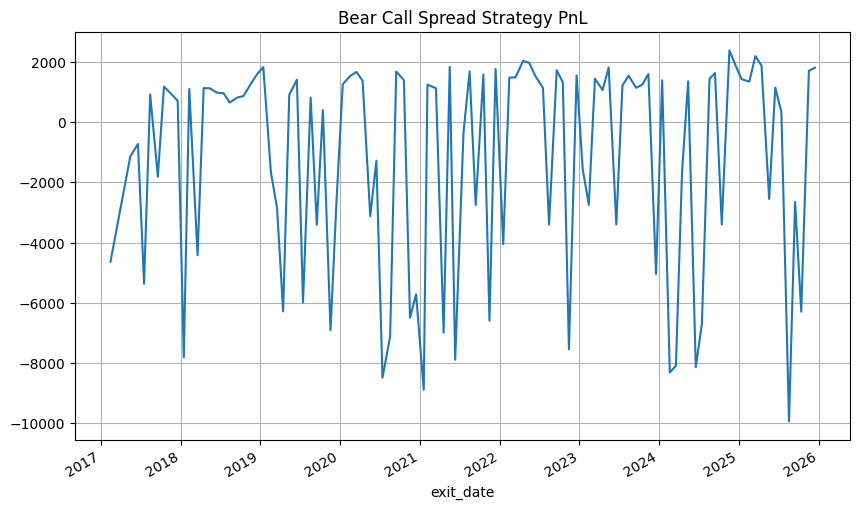

In [12]:
import matplotlib.pyplot as plt
results.set_index('exit_date')['pnl_amount'].plot(title='Bear Call Spread Strategy PnL', figsize=(10, 6))
plt.grid(True)
plt.show()

In [13]:
import pandas as pd
import numpy as np

# ... (保留原本的參數設定與 import) ...

def run_bear_call_spread_strategy_with_stop(df_opt, df_fut):
    """
    執行 Bear Call Spread 策略回測 (含觸價停損機制)
    策略：若 S > Short Strike，則強制平倉止損，當月不再進場。
    """
    print(f"=== 啟動回測 (含觸價停損): {START_DATE} 至 {END_DATE} ===")
    
    # 1. 資料與工具準備
    df_opt_clean = clean_options_data(df_opt)
    df_fut_clean = clean_futures_data(df_fut)
    
    rollover_map = build_rollover_map(
        df_fut_clean, START_DATE, END_DATE, offset=ROLLOVER_OFFSET
    )
    
    market_gen = market_data_generator(
        START_DATE, END_DATE, df_opt_clean, df_fut_clean, risk_free_rate=RISK_FREE_RATE
    )
    
    # 2. 狀態變數
    current_position = None 
    is_stopped_out = False  # 新增：標記當月是否已停損
    pnl_history = []
    
    # 3. 逐日回測
    for date, S, calls, puts in market_gen:
        
        # --- A. 停損監控 (Stop Loss Logic) ---
        # 只有在「持有部位」且「尚未停損」且「非換倉日(避免重複執行)」時檢查
        is_rollover, close_contract, open_contract = get_rollover_info(date, rollover_map)
        
        if current_position and not is_rollover:
            # 檢查條件：標的價格 S 是否漲破 Short Strike
            if S >= current_position['short_k']:
                print(f"[停損觸發] {date.date()} S={S:.0f} >= K={current_position['short_k']}")
                
                # 執行平倉
                try:
                    # 篩選當前合約報價
                    df_curr = calls[calls['到期月份(週別)'] == current_position['contract']]
                    
                    # 取得平倉價格
                    row_short = df_curr[df_curr['履約價'] == current_position['short_k']].iloc[0]
                    row_long  = df_curr[df_curr['履約價'] == current_position['long_k']].iloc[0]
                    
                    price_short_exit = row_short['收盤價']
                    price_long_exit  = row_long['收盤價']
                    
                    # 計算損益
                    exit_debit = price_short_exit - price_long_exit
                    pnl_points = current_position['entry_credit'] - exit_debit
                    
                    pnl_history.append({
                        'entry_date': current_position['entry_date'],
                        'exit_date': date,
                        'contract': current_position['contract'],
                        'S_entry': current_position['S_entry'],
                        'S_exit': S,
                        'short_k': current_position['short_k'],
                        'long_k': current_position['long_k'],
                        'entry_credit': current_position['entry_credit'],
                        'exit_debit': exit_debit,
                        'pnl_points': pnl_points,
                        'pnl_amount': pnl_points * MULTIPLIER,
                        'note': 'Stop Loss (Touch Strike)'
                    })
                    
                    # 更新狀態：清空部位，並標記已停損
                    current_position = None
                    is_stopped_out = True
                    
                except Exception as e:
                    print(f"[Error] {date.date()} 停損平倉失敗: {e}")
                    # 若失敗，可能因資料缺失，只好被迫留到下次處理
                    pass

        # --- B. 換倉日邏輯 (Rollover Logic) ---
        if is_rollover:
            # 1. 如果手上還有部位 (代表沒被停損)，正常結算平倉
            if current_position:
                if current_position['contract'] == close_contract:
                    try:
                        df_close = calls[calls['到期月份(週別)'] == close_contract]
                        price_short_exit = df_close[df_close['履約價'] == current_position['short_k']].iloc[0]['收盤價']
                        price_long_exit  = df_close[df_close['履約價'] == current_position['long_k']].iloc[0]['收盤價']
                        
                        exit_debit = price_short_exit - price_long_exit
                        pnl_points = current_position['entry_credit'] - exit_debit
                        
                        pnl_history.append({
                            'entry_date': current_position['entry_date'],
                            'exit_date': date,
                            'contract': current_position['contract'],
                            'S_entry': current_position['S_entry'],
                            'S_exit': S,
                            'short_k': current_position['short_k'],
                            'long_k': current_position['long_k'],
                            'entry_credit': current_position['entry_credit'],
                            'exit_debit': exit_debit,
                            'pnl_points': pnl_points,
                            'pnl_amount': pnl_points * MULTIPLIER,
                            'note': 'Normal Rollover'
                        })
                        current_position = None
                    except:
                        pass # 資料不足略過
            
            # 2. 建立新月份合約 (無論上個月是否停損，換倉日都視為新局開始)
            # 重置停損旗標
            is_stopped_out = False
            
            df_open = calls[calls['到期月份(週別)'] == open_contract]
            if not df_open.empty:
                valid_calls = df_open[df_open['Delta'] > 0].copy()
                if not valid_calls.empty:
                    # 找 Delta ~ 0.2
                    best_idx = (valid_calls['Delta'] - TARGET_DELTA).abs().idxmin()
                    short_leg = valid_calls.loc[best_idx]
                    k_short = short_leg['履約價']
                    k_long = k_short + FIX_WIDTH
                    
                    long_leg_df = df_open[df_open['履約價'] == k_long]
                    if not long_leg_df.empty:
                        long_leg = long_leg_df.iloc[0]
                        price_short = short_leg['收盤價']
                        price_long = long_leg['收盤價']
                        entry_credit = price_short - price_long
                        
                        current_position = {
                            'entry_date': date,
                            'contract': open_contract,
                            'short_k': k_short,
                            'long_k': k_long,
                            'entry_credit': entry_credit,
                            'S_entry': S,
                            'delta_at_open': short_leg['Delta']
                        }

    # 4. 整理結果
    df_result = pd.DataFrame(pnl_history)
    if not df_result.empty:
        df_result['cum_pnl'] = df_result['pnl_amount'].cumsum()
    
    return df_result

# ==========================================
# 執行與比較
# ==========================================
if 'df_opt' in locals() and 'df_fut' in locals():
    # 執行帶停損的版本
    results_stop = run_bear_call_spread_strategy_with_stop(df_opt, df_fut)
    
    if not results_stop.empty:
        print("\n" + "="*40)
        print("【含觸價停損機制】回測結果")
        print("="*40)
        print(f"總損益金額 : {results_stop['pnl_amount'].sum():,.0f} 元")
        print(f"交易次數   : {len(results_stop)}")
        print(f"最大回檔   : {(results_stop['cum_pnl'].cummax() - results_stop['cum_pnl']).max():,.0f} 元")
        
        # 觀察停損發生的次數
        stop_count = len(results_stop[results_stop['note'].str.contains('Stop Loss')])
        print(f"觸發停損次數: {stop_count} 次")
        print("="*40)

=== 啟動回測 (含觸價停損): 2001-12-24 至 2025-12-31 ===
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 2317932 筆
>> 選擇權資料清洗完成，共 1529628 筆。
--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 36798 筆
>> 期貨資料清洗完成，共 44990 筆。
--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 290 個換倉點。
--- 初始化市場資料生成器 (2001-12-24 to 2025-12-31) ---
>> 預計執行交易日數: 5919 天
[停損觸發] 2017-02-10 S=9600 >= K=9600.0
[停損觸發] 2017-06-06 S=10202 >= K=10200.0
[停損觸發] 2017-06-21 S=10321 >= K=10300.0
[停損觸發] 2018-01-03 S=10748 >= K=10700.0
[停損觸發] 2018-01-23 S=11241 >= K=11200.0
[停損觸發] 2018-03-09 S=10906 >= K=10900.0
[停損觸發] 2019-02-13 S=10125 >= K=10100.0
[停損觸發] 2019-04-08 S=10779 >= K=10700.0
[停損觸發] 2019-07-01 S=10707 >= K=10700.0
[停損觸發] 2019-09-09 S=10802 >= K=10800.0
[停損觸發] 2019-11-04 S=11416 >= K=11400.0
[停損觸發] 2019-12-13 S=11977 >= K=11900.0
[停損觸發] 2020-04-30 S=10813 >= K=10700.0
[停損觸發] 2020-06-04 S=11419 >= K=11300.0
[停損觸發] 2020-07-06 S=11921 >= K=11800.0
[停損觸發] 2020-07-28 S=12834 >= K=12700.0
[停損觸發] 2020-12-04 S=14022 >= K=14000.0
[停損觸發] 2021-01-05 S=14874 >= K=1

In [14]:
results_stop

,entry_date,exit_date,contract,S_entry,S_exit,short_k,long_k,entry_credit,exit_debit,pnl_points,pnl_amount,note,cum_pnl
0,2017-01-16,2017-02-10,201702,9360.0,9600.0,9600.0,9800.0,13.5,70.0,-56.5,-2825.0,Stop Loss (Touch Strike),-2825.0
1,2017-04-17,2017-05-15,201705,9740.0,9990.0,10000.0,10200.0,19.3,41.9,-22.6,-1130.0,Normal Rollover,-3955.0
2,2017-05-15,2017-06-06,201706,9990.0,10202.0,10200.0,10400.0,35.0,51.4,-16.4,-820.0,Stop Loss (Touch Strike),-4775.0
3,2017-06-19,2017-06-21,201707,10147.0,10321.0,10300.0,10500.0,19.0,38.0,-19.0,-950.0,Stop Loss (Touch Strike),-5725.0
4,2017-07-17,2017-08-14,201708,10403.0,10311.0,10600.0,10800.0,19.0,0.4,18.6,930.0,Normal Rollover,-4795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2025-07-14,2025-08-08,202508,22670.0,24091.0,23700.0,23900.0,26.0,136.0,-110.0,-5500.0,Stop Loss (Touch Strike),-72525.0
101,2025-08-18,2025-09-11,202509,24199.0,25386.0,25300.0,25500.0,37.0,79.0,-42.0,-2100.0,Stop Loss (Touch Strike),-74625.0
102,2025-09-15,2025-10-02,202510,25404.0,26459.0,26400.0,26600.0,36.0,98.0,-62.0,-3100.0,Stop Loss (Touch Strike),-77725.0
103,2025-10-13,2025-10-30,202511,26450.0,28430.0,28400.0,28600.0,35.0,92.0,-57.0,-2850.0,Stop Loss (Touch Strike),-80575.0


# 核心架構設計概念
我們將系統拆分為三個主要角色：

Data Layer (資料層)：負責提供市場快照 (Market Snapshot)，包含清洗後的價格與 Greeks。這部分沿用您現有的 Generator。

Strategy (策略層 - The Brain)：只負責 「決策」。它不碰觸金流計算，只根據市場狀況發出「交易訊號 (Signal)」。

Executor (執行層 - The Body)：負責 「運作」。它管理時間軸、帳戶損益 (PnL)、部位狀態 (Position)，並執行策略發出的訊號。

---

這是一份經過重構的物件導向架構骨架。我將系統拆解為三個部分：

`TradeSignal`: 策略與執行器溝通的標準語言。

`BaseStrategy`: 定義策略行為的介面 (Interface)。

`BacktestExecutor`: 負責跑迴圈、管帳、執行交易的核心引擎。

這種寫法讓你未來要加入 `IronCondorStrategy` 或是 `PutSellingStrategy` 時，只需要寫一個新的 class，完全不用改動回測引擎。

In [34]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np

@dataclass
class Leg:
    """定義一隻腳的屬性"""
    side: str      # 'buy' or 'sell'
    strike: float  # 履約價
    opt_type: str  # 'call' or 'put'

@dataclass
class TradeSignal:
    """策略發出的交易訊號"""
    action: str           # 'OPEN', 'CLOSE'
    legs: List[Leg]       # 這個訊號包含哪幾隻腳 (單邊或是價差)
    contract: str         # 合約月份 (e.g., '202206')
    reason: str           # 'ROLLOVER', 'STOP_LOSS', 'ENTRY'
    note: str = ""

In [35]:
class BaseStrategy(ABC):
    """策略抽象基底類別"""
    
    @abstractmethod
    def on_bar(self, context: Dict, market_data: tuple) -> List[TradeSignal]:
        """
        每日行情更新時觸發 (非換倉日)
        :param context: 當前持倉資訊 (Executor 傳入)
        :param market_data: (date, S, calls, puts)
        :return: 訊號列表
        """
        pass

    @abstractmethod
    def on_rollover(self, context: Dict, market_data: tuple, rollover_info: tuple) -> List[TradeSignal]:
        """
        換倉日觸發
        :param rollover_info: (is_rollover, close_contract, open_contract)
        :return: 訊號列表
        """
        pass

# ==========================================
# 實作範例：Bear Call Spread
# ==========================================
class BearCallSpreadStrategy(BaseStrategy):
    def __init__(self, target_delta=0.2, width=200):
        self.target_delta = target_delta
        self.width = width

    def on_bar(self, context, market_data):
        """檢查是否觸價停損"""
        date, S, calls, puts = market_data
        signals = []
        
        # 如果當前有持倉，且尚未停損
        if context['position'] is not None:
            pos = context['position']
            short_k = pos['short_k']
            
            # 觸價停損邏輯: S 漲破 Short Strike
            if S >= short_k:
                # 發出平倉訊號
                # 注意：這裡只需告訴 Executor "我要平倉"，Executor 會自己去查現在的價格
                signal = TradeSignal(
                    action='CLOSE',
                    contract=pos['contract'],
                    legs=[
                        Leg('sell', pos['short_k'], 'call'), # 原本是 Sell，平倉邏輯由 Executor 處理(買回)
                        Leg('buy', pos['long_k'], 'call')    # 原本是 Buy
                    ],
                    reason='STOP_LOSS',
                    note=f"S({S:.0f}) >= K({short_k})"
                )
                signals.append(signal)
                
        return signals

    def on_rollover(self, context, market_data, rollover_info):
        """處理換倉：平舊倉 + 建新倉"""
        date, S, calls, puts = market_data
        _, close_contract, open_contract = rollover_info
        signals = []

        # 1. 平倉舊部位 (如果有)
        if context['position'] is not None:
            pos = context['position']
            # 確保平的是正確的月份
            if pos['contract'] == close_contract:
                signal_close = TradeSignal(
                    action='CLOSE',
                    contract=close_contract,
                    legs=[
                        Leg('sell', pos['short_k'], 'call'),
                        Leg('buy', pos['long_k'], 'call')
                    ],
                    reason='ROLLOVER_CLOSE'
                )
                signals.append(signal_close)

        # 2. 建倉新部位 (篩選 Delta)
        # 這裡需要篩選邏輯
        df_open = calls[calls['到期月份(週別)'] == open_contract]
        if not df_open.empty:
            valid_calls = df_open[df_open['Delta'] > 0]
            if not valid_calls.empty:
                # 找 Delta 最接近 self.target_delta
                best_idx = (valid_calls['Delta'] - self.target_delta).abs().idxmin()
                short_leg_row = valid_calls.loc[best_idx]
                
                k_short = short_leg_row['履約價']
                k_long = k_short + self.width
                
                # 發出建倉訊號
                signal_open = TradeSignal(
                    action='OPEN',
                    contract=open_contract,
                    legs=[
                        Leg('sell', k_short, 'call'), # 賣近
                        Leg('buy', k_long, 'call')    # 買遠
                    ],
                    reason='ROLLOVER_OPEN',
                    note=f"Delta:{short_leg_row['Delta']:.2f}"
                )
                signals.append(signal_open)
        
        return signals

In [ ]:
class BacktestExecutor:
    def __init__(self, strategy: BaseStrategy, start_date, end_date, df_opt, df_fut, risk_free_rate=0.01):
        self.strategy = strategy
        self.start_date = start_date
        self.end_date = end_date
        self.df_opt = clean_options_data(df_opt) # 呼叫現有工具
        self.df_fut = clean_futures_data(df_fut) # 呼叫現有工具
        self.risk_free_rate = risk_free_rate
        
        # 狀態變數
        self.current_position = None # { 'short_k':..., 'long_k':..., 'entry_credit':... }
        self.history = []
        self.balance = 0
        
    def run(self):
        """主執行迴圈"""
        print(f"--- Executor Start: {self.start_date} ~ {self.end_date} ---")
        
        # 1. 準備環境
        rollover_map = build_rollover_map(
            self.df_fut, self.start_date, self.end_date, offset=3
        )
        
        market_gen = market_data_generator(
            self.start_date, self.end_date, self.df_opt, self.df_fut, self.risk_free_rate
        )







        # 2. 時間推進
        for date, S, calls, puts in market_gen:
            market_data = (date, S, calls, puts)
            
            # 建立 Context (讓策略知道我現在手上有什麼)
            context = {
                'position': self.current_position,
                'balance': self.balance
            }
            
            # 3. 判斷換倉狀態
            is_rollover, close_contract, open_contract = get_rollover_info(date, rollover_map)
            rollover_info = (is_rollover, close_contract, open_contract)
            
            signals = []
            if is_rollover:
                # 換倉日：呼叫策略的 on_rollover
                signals = self.strategy.on_rollover(context, market_data, rollover_info)
            else:
                # 一般日：呼叫策略的 on_bar
                signals = self.strategy.on_bar(context, market_data)
                
            # 4. 執行訊號
            for sig in signals:
                self._execute_signal(sig, market_data)
                
        # 5. 結束處理
        return pd.DataFrame(self.history)

    def _execute_signal(self, signal: TradeSignal, market_data):
        """交易執行核心：查價、算錢、記帳"""
        date, S, calls, puts = market_data
        
        # 取得報價表 (Call/Put 混合或分開查)
        # 這裡簡化：假設只做 Call Spread，只查 calls
        df_prices = calls[calls['到期月份(週別)'] == signal.contract]
        
        if signal.action == 'OPEN':
            # --- 建倉邏輯 ---
            # 1. 查兩隻腳的價格
            prices = {}
            for leg in signal.legs:
                p = self._get_price(df_prices, leg.strike)
                prices[leg.strike] = p
            
            # 2. 計算權利金 (Credit Strategy: Sell Price - Buy Price)
            # 假設 legs[0] 是 Sell, legs[1] 是 Buy (依照策略寫法)
            short_leg = next(l for l in signal.legs if l.side == 'sell')
            long_leg = next(l for l in signal.legs if l.side == 'buy')
            
            credit = prices[short_leg.strike] - prices[long_leg.strike]
            
            # 3. 更新狀態
            self.current_position = {
                'contract': signal.contract,
                'short_k': short_leg.strike,
                'long_k': long_leg.strike,
                'entry_price_short': prices[short_leg.strike],
                'entry_price_long': prices[long_leg.strike],
                'entry_credit': credit,
                'entry_date': date,
                'S_entry': S
            }
            # print(f"[{date.date()}] OPEN: {signal.contract} +{credit:.1f}")

        elif signal.action == 'CLOSE':
            # --- 平倉邏輯 ---
            if self.current_position:
                # 1. 查平倉價格
                # 注意：Buy to Cover (Debit)
                # 原本 Sell 的要 Buy 回，原本 Buy 的要 Sell 掉
                prices = {}
                for leg in signal.legs:
                    p = self._get_price(df_prices, leg.strike)
                    prices[leg.strike] = p
                    
                pos = self.current_position
                
                # 計算平倉成本 (Debit = Short_Exit - Long_Exit)
                exit_price_short = prices[pos['short_k']]
                exit_price_long = prices[pos['long_k']]
                debit = exit_price_short - exit_price_long
                
                pnl = pos['entry_credit'] - debit
                
                # 2. 寫入歷史
                self.history.append({
                    'entry_date': pos['entry_date'],
                    'exit_date': date,
                    'contract': pos['contract'],
                    'short_k': pos['short_k'],
                    'long_k': pos['long_k'],
                    'entry_credit': pos['entry_credit'],
                    'exit_debit': debit,
                    'pnl_points': pnl,
                    'reason': signal.reason,
                    'note': signal.note
                })
                
                # 3. 清空狀態
                self.current_position = None
                # print(f"[{date.date()}] CLOSE: {signal.contract} PnL:{pnl:.1f} ({signal.reason})")

    def _get_price(self, df, strike):
        """輔助函式：安全查價 (若無價格用0或報錯)"""
        try:
            row = df[df['履約價'] == strike].iloc[0]
            return row['收盤價']
        except:
            return 0.0 # 或拋出異常

## 使用方式 (Usage)
這樣設計後，使用者的呼叫介面會變得非常乾淨：


```python
# 1. 設定策略
my_strategy = BearCallSpreadStrategy(
    target_delta=0.2, 
    width=200
)

# 2. 初始化執行器
executor = BacktestExecutor(
    strategy=my_strategy,
    start_date='2001-12-24',
    end_date='2025-12-31',
    df_opt=df_opt,  # 原始資料
    df_fut=df_fut   # 原始資料
)

# 3. 執行
results_df = executor.run()

# 4. 看結果
print(results_df.head())
print(f"Total PnL: {results_df['pnl_points'].sum() * 50}")
```

# test

In [18]:
import pandas as pd
import numpy as np

# 假設 BaseStrategy, BacktestExecutor, TradeSignal, Leg 等類別已經定義在上面

def run_unit_tests():
    print("========================================")
    print("🚀 啟動零件測試方案 (Unit Tests)")
    print("========================================\n")

    # ------------------------------------------------
    # T1: 資料結構測試
    # ------------------------------------------------
    print("[T1] 測試訊號結構 (TradeSignal Structure)...")
    try:
        leg1 = Leg(side='sell', strike=18000, opt_type='call')
        leg2 = Leg(side='buy', strike=18200, opt_type='call')
        sig = TradeSignal(action='OPEN', legs=[leg1, leg2], contract='202206', reason='TEST')
        
        assert sig.legs[0].strike == 18000
        assert sig.action == 'OPEN'
        print("   >> PASS: 訊號結構正確。\n")
    except Exception as e:
        print(f"   >> FAIL: {e}\n")

    # ------------------------------------------------
    # T2: 策略邏輯測試 (Strategy)
    # ------------------------------------------------
    print("[T2] 測試策略邏輯 (Strategy Logic)...")
    strategy = BearCallSpreadStrategy(target_delta=0.2, width=200)
    
    # 準備 Mock 資料 (模擬某天的選擇權報價)
    mock_calls = pd.DataFrame([
        {'履約價': 17800, '收盤價': 300, 'Delta': 0.45, '到期月份(週別)': '202206'},
        {'履約價': 18000, '收盤價': 150, 'Delta': 0.21, '到期月份(週別)': '202206'}, # Target (最接近 0.2)
        {'履約價': 18200, '收盤價': 50,  'Delta': 0.10, '到期月份(週別)': '202206'}, # Long Leg
    ])
    mock_puts = pd.DataFrame() # 沒用到 Put
    mock_S = 17500
    mock_date = pd.Timestamp('2022-05-18')
    market_data = (mock_date, mock_S, mock_calls, mock_puts)

    # --- T2-1: 測試建倉 (Rollover Open) ---
    print("   [T2-1] 測試建倉訊號選股...")
    # 模擬換倉日: 平 202205, 建 202206
    rollover_info = (True, '202205', '202206') 
    context = {'position': None} # 目前空手

    signals = strategy.on_rollover(context, market_data, rollover_info)
    
    # 驗證是否發出 OPEN 訊號
    open_sig = next((s for s in signals if s.action == 'OPEN'), None)
    
    if open_sig:
        short_leg = next(l for l in open_sig.legs if l.side == 'sell')
        if short_leg.strike == 18000:
            print(f"   >> PASS: 正確選中 Delta~0.2 的履約價 18000 (Delta 0.21)")
        else:
            print(f"   >> FAIL: 選中錯誤履約價 {short_leg.strike}")
    else:
        print("   >> FAIL: 未發出建倉訊號")

    # --- T2-2: 測試停損 (Stop Loss) ---
    print("   [T2-2] 測試觸價停損訊號...")
    # 模擬持倉: Short 18000
    context_pos = {
        'position': {
            'contract': '202206', 
            'short_k': 18000, 
            'long_k': 18200, 
            'entry_credit': 100
        }
    }
    # 模擬行情大漲至 18050 (大於 Short Strike 18000)
    high_S = 18050 
    market_data_high = (mock_date, high_S, mock_calls, mock_puts)
    
    signals = strategy.on_bar(context_pos, market_data_high)
    close_sig = next((s for s in signals if s.action == 'CLOSE' and s.reason == 'STOP_LOSS'), None)
    
    if close_sig:
        print(f"   >> PASS: S={high_S} >= K=18000，正確觸發停損訊號。")
    else:
        print(f"   >> FAIL: 未觸發停損訊號 (Signals: {signals})")
    print()

    # ------------------------------------------------
    # T3: 執行器運算測試 (Executor)
    # ------------------------------------------------
    print("[T3] 測試執行器運算 (Executor Calculation)...")
    
    # 初始化一個空的 Executor (傳入空的 DataFrame 避免報錯)
    empty_df = pd.DataFrame(columns=['交易日期', '契約', '到期月份(週別)', '開盤價', '收盤價', '履約價', '交易時段'])
    executor = BacktestExecutor(strategy, '2022-01-01', '2022-01-02', empty_df, empty_df)
    
    # --- T3-1: 模擬執行建倉 ---
    print("   [T3-1] 模擬執行建倉 (OPEN)...")
    # 造一個 OPEN 訊號: Sell 18000 @ 150, Buy 18200 @ 50
    # 預期 Credit = 150 - 50 = 100
    sig_open = TradeSignal(
        action='OPEN', contract='202206', reason='TEST_ENTRY',
        legs=[Leg('sell', 18000, 'call'), Leg('buy', 18200, 'call')]
    )
    
    # 執行 (使用 mock_calls 讓它查得到價格)
    executor._execute_signal(sig_open, market_data)
    
    pos = executor.current_position
    if pos and pos['entry_credit'] == 100 and pos['short_k'] == 18000:
        print(f"   >> PASS: 部位建立正確。Credit={pos['entry_credit']}")
    else:
        print(f"   >> FAIL: 部位狀態錯誤: {pos}")

    # --- T3-2: 模擬執行平倉 ---
    print("   [T3-2] 模擬執行平倉 (CLOSE)...")
    # 造一個 CLOSE 訊號
    # 假設現在價格變了: 18000 漲到 200, 18200 漲到 80
    # Debit = 200 - 80 = 120
    # PnL = Credit(100) - Debit(120) = -20
    
    mock_calls_exit = pd.DataFrame([
        {'履約價': 18000, '收盤價': 200, '到期月份(週別)': '202206'},
        {'履約價': 18200, '收盤價': 80,  '到期月份(週別)': '202206'},
    ])
    market_data_exit = (mock_date, mock_S, mock_calls_exit, mock_puts)
    
    sig_close = TradeSignal(
        action='CLOSE', contract='202206', reason='TEST_EXIT',
        legs=[Leg('sell', 18000, 'call'), Leg('buy', 18200, 'call')]
    )
    
    executor._execute_signal(sig_close, market_data_exit)
    
    if len(executor.history) == 1:
        record = executor.history[0]
        if record['pnl_points'] == -20:
            print(f"   >> PASS: 損益計算正確。PnL = {record['pnl_points']}")
        else:
            print(f"   >> FAIL: 損益計算錯誤。Expected -20, Got {record['pnl_points']}")
    else:
        print("   >> FAIL: 交易紀錄未寫入。")

    print("\n✅ 所有零件測試完成。")

# 執行測試
if __name__ == "__main__":
    # 確保前面已經定義了所有 Class
    try:
        run_unit_tests()
    except NameError as e:
        print(f"錯誤: 找不到類別定義 ({e})。請確保 Strategy 與 Executor 的 Class 代碼已執行。")

🚀 啟動零件測試方案 (Unit Tests)

[T1] 測試訊號結構 (TradeSignal Structure)...
   >> PASS: 訊號結構正確。

[T2] 測試策略邏輯 (Strategy Logic)...
   [T2-1] 測試建倉訊號選股...
   >> PASS: 正確選中 Delta~0.2 的履約價 18000 (Delta 0.21)
   [T2-2] 測試觸價停損訊號...
   >> PASS: S=18050 >= K=18000，正確觸發停損訊號。

[T3] 測試執行器運算 (Executor Calculation)...
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 0 筆
>> 選擇權資料清洗完成，共 0 筆。
--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 0 筆
>> 期貨資料清洗完成，共 0 筆。
   [T3-1] 模擬執行建倉 (OPEN)...
   >> PASS: 部位建立正確。Credit=100
   [T3-2] 模擬執行平倉 (CLOSE)...
   >> PASS: 損益計算正確。PnL = -20

✅ 所有零件測試完成。


# The Wheel Strategy

In [71]:
class BacktestExecutor:
    def __init__(self, strategy: BaseStrategy, start_date, end_date, df_opt, df_fut, risk_free_rate=0.01):
        self.strategy = strategy
        self.start_date = start_date
        self.end_date = end_date
        self.df_opt = clean_options_data(df_opt) # 呼叫現有工具
        self.df_fut = clean_futures_data(df_fut) # 呼叫現有工具
        self.risk_free_rate = risk_free_rate
        
        # 狀態變數
        self.current_position = None # { 'short_k':..., 'long_k':..., 'entry_credit':... }
        self.history = []
        self.balance = 0
        
    def run(self):
        """主執行迴圈"""
        print(f"--- Executor Start: {self.start_date} ~ {self.end_date} ---")
        
        # 1. 準備環境
        rollover_map = build_rollover_map(
            self.df_fut, self.start_date, self.end_date, offset=3
        )
        
        market_gen = market_data_generator(
            self.start_date, self.end_date, self.df_opt, self.df_fut, self.risk_free_rate
        )
        
        # 2. 時間推進
        for date, S, calls, puts in market_gen:
            market_data = (date, S, calls, puts)
            
            # 建立 Context (讓策略知道我現在手上有什麼)
            context = {
                'position': self.current_position,
                'balance': self.balance
            }
            
            # 3. 判斷換倉狀態
            is_rollover, close_contract, open_contract = get_rollover_info(date, rollover_map)
            rollover_info = (is_rollover, close_contract, open_contract)
            
            signals = []
            if is_rollover:
                # 換倉日：呼叫策略的 on_rollover
                signals = self.strategy.on_rollover(context, market_data, rollover_info)
            else:
                # 一般日：呼叫策略的 on_bar
                signals = self.strategy.on_bar(context, market_data)
                
            # 4. 執行訊號
            for sig in signals:
                self._execute_signal(sig, market_data)
                
        # 5. 結束處理
        return pd.DataFrame(self.history)
        
    def _execute_signal(self, signal, market_data):
            date, S, calls, puts = market_data
            
            # 1. 準備報價表
            df_prices = pd.concat([calls, puts])
            if '到期月份(週別)' in df_prices.columns:
                df_prices = df_prices[df_prices['到期月份(週別)'] == signal.contract]


            # 🟢 [修正] 讀取訊號中的 quantity，若沒設定預設為 1
            trade_qty = getattr(signal, 'quantity', 1)

            # --- 建倉邏輯 ---
            if signal.action == 'OPEN':
                net_cash_flow = 0.0
                legs_record = []
                
                # 遍歷每一隻腳位 (Leg)
                for leg in signal.legs:
                    try:
                        # A. 查價
                        cond = (df_prices['履約價'] == leg.strike) & \
                            (df_prices['買賣權'] == ('買權' if leg.opt_type == 'call' else '賣權'))
                        
                        if cond.sum() == 0: 
                            print(f"[{date.date()}] 缺報價無法建倉: {leg}")
                            return 
                        
                        price = df_prices[cond].iloc[0]['收盤價']
                        
                        # B. 計算單口現金流
                        direction = 1 if leg.side == 'sell' else -1
                        
                        # 🟢 [修正] 這裡要乘上 trade_qty
                        leg_total_flow = (price * direction) * trade_qty
                        
                        net_cash_flow += leg_total_flow

                        # C. 儲存詳細資訊 (新增部分)
                        legs_record.append({
                            'side': leg.side,       # 'buy'/'sell'
                            'type': leg.opt_type,   # 'call'/'put'
                            'strike': leg.strike,
                            'entry_price': price,
                            'contract': signal.contract,
                            'qty': trade_qty  # 🟢 記錄口數以便平倉使用
                        })
                        

                    except Exception as e:
                        print(f"建倉查價錯誤: {e}")
                        return

                total_premium = net_cash_flow * 50
                self.balance += total_premium
                
                # D. 更新持倉狀態
                self.current_position = {
                    'legs': legs_record,        # 這裡存了所有細節
                    'total_premium': total_premium,
                    'entry_date': date,
                    'entry_index': S,           # 紀錄進場時的大盤點數
                    'strategy_mode': getattr(self.strategy, 'mode', 'N/A')
                }

            # --- 平倉邏輯 ---
            elif signal.action == 'CLOSE' and self.current_position:
                close_cash_flow = 0.0
                legs_detail_str = [] # 用來組合成易讀的字串
                
                # 遍歷持倉中的腳位進行平倉
                for leg_data in self.current_position['legs']:
                    try:
                        # A. 查平倉價
                        cond = (df_prices['履約價'] == leg_data['strike']) & \
                            (df_prices['買賣權'] == ('買權' if leg_data['type'] == 'call' else '賣權'))
                        
                        if cond.sum() > 0:
                            exit_price = df_prices[cond].iloc[0]['收盤價']
                        else:
                            # 備案：結算邏輯
                            strike = leg_data['strike']
                            if leg_data['type'] == 'call': exit_price = max(0, S - strike)
                            else: exit_price = max(0, strike - S)
                            
                        # B. 計算平倉現金流
                        # 取出當時建倉的口數
                        leg_qty = leg_data.get('qty', 1)

                        direction = -1 if leg_data['side'] == 'sell' else 1
                        
                        # 🟢 [修正] 平倉也要乘上口數
                        close_cash_flow += (exit_price * direction) * leg_qty
                        
                        # C. 組合詳細資訊字串 (Entry -> Exit)
                        # 格式範例: "Sell Put 17000 (150.0 -> 20.0)"
                        detail = (f"{leg_data['side'].title()} {leg_data['type'].title()} "
                                f"{int(leg_data['strike'])} "
                                f"({leg_data['entry_price']}->{exit_price})")
                        legs_detail_str.append(detail)
                        
                    except Exception as e:
                        print(f"平倉查價錯誤: {e}")

                # D. 計算總損益
                # 總損益 = 初始權利金 + 平倉現金流 (平倉通常是負的，代表付錢)
                pnl = self.current_position['total_premium'] + (close_cash_flow * 50)
                self.balance += (close_cash_flow * 50)
                
                # E. 寫入歷史紀錄 (包含您要求的所有欄位)
                self.history.append({
                    'entry_date': self.current_position['entry_date'],
                    'exit_date': date,
                    'mode': self.current_position.get('strategy_mode'), # 策略當下狀態
                    'reason': signal.reason,
                    
                    # 損益數據
                    'pnl': pnl,
                    'balance': self.balance,
                    'roi_pct': 0 if self.current_position['total_premium'] == 0 else (pnl / abs(self.current_position['total_premium'])),
                    
                    # 詳細訂單資訊
                    'trade_detail': " | ".join(legs_detail_str), # 易讀字串
                    'entry_index': self.current_position['entry_index'], # 進場大盤
                    'exit_index': S,  # 出場大盤
                    
                    # 若需要原始數據做分析，也可保留 raw data (選擇性)
                    # 'raw_legs': self.current_position['legs'] 
                })
                
                self.current_position = None
                
    def _get_price(self, df, strike):
        """輔助函式：安全查價 (若無價格用0或報錯)"""
        try:
            row = df[df['履約價'] == strike].iloc[0]
            return row['收盤價']
        except:
            return 0.0 # 或拋出異常

In [ ]:
import pandas as pd
import numpy as np
from abc import ABC, abstractmethod
from typing import List, Dict, Optional

# # --- 模擬文檔中定義的基礎架構 (若您已有檔案可忽略此區塊，直接看 Strategy) ---
# class Leg:
#     def __init__(self, side: str, strike: float, opt_type: str):
#         self.side = side        # 'buy' or 'sell'
#         self.strike = strike
#         self.opt_type = opt_type # 'call' or 'put'

#     def __repr__(self):
#         return f"{self.side.upper()} {self.opt_type.upper()} @ {self.strike}"

# class TradeSignal:
#     def __init__(self, action: str, contract: str, legs: List[Leg], reason: str):
#         self.action = action    # 'OPEN' or 'CLOSE'
#         self.contract = contract
#         self.legs = legs
#         self.reason = reason

# class BaseStrategy(ABC):
#     @abstractmethod
#     def on_bar(self, context, market_data) -> List[TradeSignal]:
#         pass
#     @abstractmethod
#     def on_rollover(self, context, market_data, rollover_info) -> List[TradeSignal]:
#         pass

# --- 策略核心代碼 ---
class TheWheelStrategy(BaseStrategy):
    def __init__(self, leverage: float = 3.0, put_delta: float = -0.2):
        self.leverage = leverage
        self.target_put_delta = put_delta
        
        self.mode = 'PUT' 
        self.virtual_cost = 0.0 
        # 為了判斷結算，我們需要知道上一期的持倉履約價
        # 簡化：在 on_bar 或 context 應該要能傳入，這裡暫存
        self.last_strike = None 
        self.last_type = None

    def on_bar(self, context, market_data) -> List[TradeSignal]:
        return []
    
    def on_rollover(self, context, market_data, rollover_info) -> List[TradeSignal]:
            # --- 1. 解包 Tuple ---
            is_rollover, close_contract, open_contract = rollover_info
            
            date, S, calls, puts = market_data
            balance = context['balance']
            position = context.get('position')
            
            signals = []

            # --- 2. 平倉邏輯 (如果有持倉) ---
            if position:
                # 這裡假設您的 Executor 儲存結構為 {'legs': [...]}
                # 如果您的 Executor 沒有 legs 欄位，請檢查 _execute_signal 的儲存結構
                if 'legs' in position and len(position['legs']) > 0:
                    my_leg = position['legs'][0] # 取第一隻腳判斷
                    strike = my_leg['strike']
                    opt_type = my_leg['type']
                    
                    # 判斷是否被穿價 (ITM)
                    is_itm = False
                    if opt_type == 'put' and S < strike:
                        is_itm = True
                    elif opt_type == 'call' and S > strike:
                        is_itm = True
                    
                    # 發出平倉訊號
                    close_leg = Leg(side=my_leg['side'], strike=strike, opt_type=opt_type)
                    signals.append(TradeSignal(
                        action='CLOSE', 
                        contract=close_contract, 
                        legs=[close_leg], 
                        reason='Rollover_Close'
                    ))

                    # 狀態切換邏輯
                    if self.mode == 'PUT':
                        if is_itm:
                            self.mode = 'CALL'
                            self.virtual_cost = strike 
                            # print(f">> [轉折] {date.date()} Put ITM. 轉 CALL. Cost: {self.virtual_cost}")
                    elif self.mode == 'CALL':
                        if is_itm:
                            self.mode = 'PUT'
                            self.virtual_cost = 0
                            # print(f">> [轉折] {date.date()} Call ITM. 獲利出場. 回歸 PUT.")

            # --- 3. 建倉邏輯 ---
            qty = max(1, int((balance * self.leverage) / (S * 50)))
            target_leg = None
            
            if self.mode == 'PUT':
                # 🟢 [修正點在此] 找 Delta -0.2 的 Put
                # 使用 .iloc 來透過位置選取
                try:
                    # 算出與目標 Delta 的差距
                    diff = (puts['Delta'] - self.target_put_delta).abs()
                    # 排序後取最小的索引位置 (int)
                    idx = diff.argsort().iloc[0] 
                    # 使用 .iloc 取得該列
                    candidate = puts.iloc[idx]
                    
                    k = candidate['履約價']
                    target_leg = Leg('sell', k, 'put')
                except Exception as e:
                    # 避免當天沒有 Put 資料導致崩潰
                    print(f"[{date.date()}] 找不到合適 Put: {e}")
                    
            elif self.mode == 'CALL':
                # 找 Strike > Virtual Cost 的 Call
                # 這裡用 boolean mask (True/False)，不需要用 iloc，直接 [] 即可
                candidates = calls[calls['履約價'] >= self.virtual_cost].sort_values('履約價')
                
                if not candidates.empty:
                    # 選第一檔 (最接近成本的價外)
                    k = candidates.iloc[0]['履約價']
                    target_leg = Leg('sell', k, 'call')
                else:
                    # 找不到 (可能大跌)，只好選最高的履約價
                    if not calls.empty:
                        k = calls['履約價'].max()
                        target_leg = Leg('sell', k, 'call')

            if target_leg:
                signals.append(TradeSignal(
                    action='OPEN',
                    contract=open_contract,
                    legs=[target_leg],
                    reason=f"Wheel_{self.mode}"
                ))
                
            return signals


import pandas as pd
import numpy as np
from typing import List, Optional

class EnhancedWheelStrategy(BaseStrategy):
    def __init__(self, 
                 leverage: float = 3.0, 
                 target_delta: float = 0.20,     # 入場 Delta 目標 (絕對值)
                 stop_loss_delta: float = 0.60,  # [風控] Delta 超過此值強制止損
                 profit_take_pct: float = 0.80,  # [獲利] 權利金收到 80% 提早平倉
                 gamma_risk_days: int = 5        # [風控] 剩餘天數小於此值且 ATM 時平倉
                 ):
        self.leverage = leverage
        self.target_delta = target_delta
        self.stop_loss_delta = stop_loss_delta
        self.profit_take_pct = profit_take_pct
        self.gamma_risk_days = gamma_risk_days
        
        # 狀態變數
        self.mode = 'PUT'  # 'PUT' or 'CALL'
        self.virtual_cost = 0.0 
        self.accumulated_pnl = 0.0 # 用來追蹤這一輪 Wheel 的總損益

    def on_bar(self, context, market_data) -> List[TradeSignal]:
        """
        每日監控：檢查是否觸發 Greeks 風控或提早獲利
        """
        date, S, calls, puts = market_data
        position = context.get('position')
        signals = []

        if not position or not position.get('legs'):
            return []

        # 取得當前持倉的最新 Greeks 與報價
        # 假設 position['legs'][0] 是我們的主要部位
        my_leg = position['legs'][0]
        strike = my_leg['strike']
        opt_type = my_leg['type']
        
        # 查報價表
        df_chain = calls if opt_type == 'call' else puts
        try:
            current_row = df_chain[df_chain['履約價'] == strike].iloc[0]
            current_price = current_row['收盤價']
            current_delta = abs(current_row['Delta'])
            current_gamma = current_row['Gamma']
            current_dt = current_row['dT'] * 252 # 換算回天數
        except:
            return [] # 查不到價不做動作

        entry_price = my_leg['entry_price']

        # --- 判斷邏輯 1: 提早獲利 (Profit Taking) ---
        # 邏輯: 權利金已經吃了 profit_take_pct (例如 80%)，價格剩 20%
        if current_price <= entry_price * (1 - self.profit_take_pct):
            signals.append(self._create_close_signal(position, f"TakeProfit_{self.profit_take_pct*100}%"))
            return signals

        # --- 判斷邏輯 2: Delta 止損 (Trend Reversal) ---
        # 邏輯: 賣 Put 後遇到大跌，Delta 從 0.2 變成 0.6 (變實值了)，認賠重來或轉倉
        if current_delta > self.stop_loss_delta:
            signals.append(self._create_close_signal(position, f"StopLoss_Delta_{current_delta:.2f}"))
            # 注意: 這裡平倉後，下一次 rollover 會重新判斷進場
            # 視為這一輪失敗，是否切換模式取決於 on_rollover 的邏輯，這裡先單純出場
            return signals

        # --- 判斷邏輯 3: Gamma 風險規避 (Gamma Risk) ---
        # 邏輯: 快到期了 (dT < 5天) 且股價在履約價附近 (Delta > 0.4)，Gamma 風險巨大
        if current_dt < self.gamma_risk_days and current_delta > 0.4:
             signals.append(self._create_close_signal(position, "RiskAversion_HighGamma"))
             return signals

        return signals

    def on_rollover(self, context, market_data, rollover_info) -> List[TradeSignal]:
        """
        換倉/進場邏輯：使用 Greeks 挑選最佳履約價
        """
        is_rollover, close_contract, open_contract = rollover_info
        date, S, calls, puts = market_data
        balance = context['balance']
        position = context.get('position')
        
        signals = []

        # 1. 處理舊倉 (如果還沒被 on_bar 平掉)
        if position:
            leg_info = position['legs'][0]
            close_signal = self._create_close_signal(position, "Rollover_Expiry")
            signals.append(close_signal)
            
            # 更新狀態機 (State Machine Update)
            # 判斷是否被穿價 (ITM)
            strike = leg_info['strike']
            is_itm = (leg_info['type'] == 'put' and S < strike) or \
                     (leg_info['type'] == 'call' and S > strike)

            if self.mode == 'PUT':
                if is_itm:
                    self.mode = 'CALL'
                    self.virtual_cost = strike
                    print(f">> [轉折] Put ITM. 切換至 CALL 救援模式. 成本: {self.virtual_cost}")
            elif self.mode == 'CALL':
                if is_itm:
                    self.mode = 'PUT' # 救援成功(被Call走) 或 失敗(大漲)，都回歸 Put
                    self.virtual_cost = 0
                    print(f">> [轉折] Call ITM. 任務結束. 回歸 PUT 模式.")

        # 2. 建立新倉 (Entry Logic with Greeks)
        # ----------------------------------------------------
        qty = max(1, int((balance * self.leverage) / (S * 50)))
        target_leg = None
        
        # 篩選當月(或次月)合約
        # 假設 calls/puts 已經是我們要交易的月份 (由外部 generator 控制或這裡篩選)
        # 這裡假設 market_data 傳入的是當日所有報價，需篩選 open_contract
        # 若您的 generator 已經篩選好，則不需要這一步
        # current_calls = calls[calls['到期月份'] == open_contract] 
        
        if self.mode == 'PUT':
            # --- Put Mode 選股邏輯 ---
            # 1. 基礎: 找 Delta 最接近 target_delta 的
            # 2. 進階: 確保 Itm_Prob 不過高 (雙重驗證)
            # 3. 進階: 選擇 Vega 較高者 (IV 高) - 這裡簡化為選 Delta 符合者
            
            candidates = puts[
                (puts['到期月份(週別)'] == open_contract) &
                (puts['Itm_Prob'] < 0.35) # 安全濾網
            ].copy()
            
            if candidates.empty:
                 # 若太嚴格找不到，放寬條件
                 candidates = puts[puts['到期月份(週別)'] == open_contract].copy()

            if not candidates.empty:
                # 找絕對值 Delta 最接近 0.2 的
                candidates['delta_diff'] = (candidates['Delta'].abs() - self.target_delta).abs()
                best_row = candidates.sort_values('delta_diff').iloc[0]
                target_leg = Leg('sell', best_row['履約價'], 'put')

        elif self.mode == 'CALL':
            # --- Call Mode (救援) 選股邏輯 ---
            # 條件 1: 履約價 > 虛擬成本 (這是死命令，不然會實現虧損)
            # 條件 2: 在滿足條件1下，找 Delta 最大的 (權利金最多，回本最快)
            # 但要注意：如果 Delta 太大 (>0.5) 代表很容易被穿價，可能要保守一點
            
            candidates = calls[
                (calls['到期月份(週別)'] == open_contract) & 
                (calls['履約價'] >= self.virtual_cost)
            ].copy()
            
            if not candidates.empty:
                # 挑選 Delta 最接近 0.3 的 (既有肉吃，又稍微有點距離)
                # 如果找不到，就選履約價最低的那一個 (premium 最高)
                candidates['delta_diff'] = (candidates['Delta'].abs() - 0.30).abs()
                best_row = candidates.sort_values('delta_diff').iloc[0]
                target_leg = Leg('sell', best_row['履約價'], 'call')
            else:
                # 極端狀況：成本太高，市場價格太低，找不到上面的 Call
                # 策略選擇：暫停交易，或賣出最遠月、最高履約價的 Call 加減補
                pass 
            
        if target_leg:
            # 建立訊號物件
            signal = TradeSignal(
                action='OPEN',
                contract=open_contract,
                legs=[target_leg],
                reason=f"Wheel_{self.mode}"
            )
            # 🟢 [修正] 將計算出的 qty 綁定到訊號上
            signal.quantity = qty 
            
            signals.append(signal)
        return signals

    def _create_close_signal(self, position, reason) -> TradeSignal:
        """輔助函式：產生平倉訊號"""
        # 假設 position['legs'] 只有一隻腳
        leg_data = position['legs'][0]
        close_leg = Leg(side=leg_data['side'], strike=leg_data['strike'], opt_type=leg_data['type'])
        
        # contract 需從 position 取得 (假設有存)
        contract = position.get('contract', 'Unknown') 
        
        return TradeSignal(
            action='CLOSE',
            contract=contract,
            legs=[close_leg],
            reason=reason
        )


import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# --- 主執行區塊 (請確保 df_opt, df_fut 已載入環境) ---
# 假設 df_opt, df_fut 已經存在於您的變數中
# 如果沒有，請取消註解以下兩行來生成假資料測試
# df_fut, df_opt = generate_dummy_data() # 自定義生成函數
# df_fut_clean = clean_futures_data(df_fut)
# df_opt_clean = clean_options_data(df_opt)

# try:
# 1. 初始化策略
# strategy = TheWheelStrategy(leverage=3.0, put_delta=-0.2)
strategy = EnhancedWheelStrategy(leverage=3.0, target_delta=0.20, stop_loss_delta=0.60, profit_take_pct=0.80, gamma_risk_days=5)

# 2. 執行回測
# 注意：請傳入您真實的 DataFrame
start_date, end_date = '2015-01-01', '2025-12-31'
executor = BacktestExecutor(strategy, start_date, end_date, df_opt_clean, df_fut_clean)#, start_balance=2_000_000)
return_value = executor.run()

# except NameError:
#     print("錯誤: 尚未定義 df_opt 或 df_fut。請確保您已載入清洗後的資料。")
# except Exception as e:
#     print(f"執行錯誤: {e}")

--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 0 筆
>> 選擇權資料清洗完成，共 1529628 筆。
--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 0 筆
>> 期貨資料清洗完成，共 44990 筆。
--- Executor Start: 2015-01-01 ~ 2025-12-31 ---
--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 133 個換倉點。
--- 初始化市場資料生成器 (2015-01-01 to 2025-12-31) ---
>> 預計執行交易日數: 2682 天


In [78]:
dir(executor)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_execute_signal',
 '_get_price',
 'balance',
 'current_position',
 'df_fut',
 'df_opt',
 'end_date',
 'history',
 'risk_free_rate',
 'run',
 'start_date',
 'strategy']

In [82]:
executor.history

[{'entry_date': Timestamp('2017-01-16 00:00:00'),
  'exit_date': Timestamp('2017-01-17 00:00:00'),
  'mode': 'PUT',
  'reason': 'TakeProfit_80.0%',
  'pnl': 2100.0,
  'balance': 2100.0,
  'roi_pct': 1.0,
  'trade_detail': 'Sell Put 9000 (42.0->0)',
  'entry_index': 9360.0,
  'exit_index': 9282.0},
 {'entry_date': Timestamp('2017-02-13 00:00:00'),
  'exit_date': Timestamp('2017-02-14 00:00:00'),
  'mode': 'PUT',
  'reason': 'TakeProfit_80.0%',
  'pnl': 1625.0,
  'balance': 3725.0,
  'roi_pct': 1.0,
  'trade_detail': 'Sell Put 9400 (32.5->0)',
  'entry_index': 9670.0,
  'exit_index': 9729.0},
 {'entry_date': Timestamp('2017-03-13 00:00:00'),
  'exit_date': Timestamp('2017-03-14 00:00:00'),
  'mode': 'PUT',
  'reason': 'TakeProfit_80.0%',
  'pnl': 2050.0,
  'balance': 5775.0,
  'roi_pct': 1.0,
  'trade_detail': 'Sell Put 9400 (41.0->0)',
  'entry_index': 9644.0,
  'exit_index': 9713.0},
 {'entry_date': Timestamp('2017-04-17 00:00:00'),
  'exit_date': Timestamp('2017-04-18 00:00:00'),
  'm

In [76]:
return_value

,entry_date,exit_date,mode,reason,pnl,balance,roi_pct,trade_detail,entry_index,exit_index
0,2017-01-16,2017-01-17,PUT,TakeProfit_80.0%,2100.0,2100.0,1.0,Sell Put 9000 (42.0->0),9360.0,9282.0
1,2017-02-13,2017-02-14,PUT,TakeProfit_80.0%,1625.0,3725.0,1.0,Sell Put 9400 (32.5->0),9670.0,9729.0
2,2017-03-13,2017-03-14,PUT,TakeProfit_80.0%,2050.0,5775.0,1.0,Sell Put 9400 (41.0->0),9644.0,9713.0
3,2017-04-17,2017-04-18,PUT,TakeProfit_80.0%,2500.0,8275.0,1.0,Sell Put 9400 (50.0->0),9740.0,9757.0
4,2017-05-15,2017-05-16,PUT,TakeProfit_80.0%,1575.0,9850.0,1.0,Sell Put 9700 (31.5->0),9990.0,10023.0
...,...,...,...,...,...,...,...,...,...,...
103,2025-08-18,2025-08-19,PUT,TakeProfit_80.0%,7800.0,570100.0,1.0,Sell Put 23200 (156.0->0),24199.0,24380.0
104,2025-09-15,2025-09-16,PUT,TakeProfit_80.0%,9700.0,579800.0,1.0,Sell Put 24200 (194.0->0),25404.0,25420.0
105,2025-10-13,2025-10-14,PUT,TakeProfit_80.0%,11600.0,591400.0,1.0,Sell Put 24900 (232.0->0),26450.0,27269.0
106,2025-11-17,2025-11-18,PUT,TakeProfit_80.0%,12850.0,604250.0,1.0,Sell Put 25800 (257.0->0),27570.0,27142.0


In [ ]:
# 3. 視覺化結果
plt.figure(figsize=(12, 8))

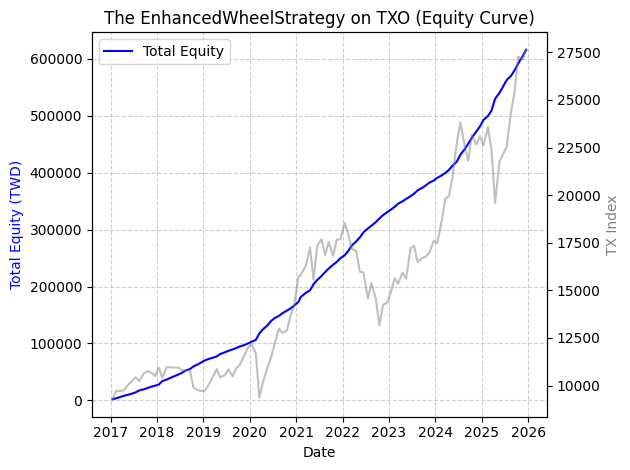

回測結束。最終權益: 615,650 (-69.22%)
總交易次數: 108
交易紀錄摘要:


In [70]:

# 3. 視覺化結果
# plt.figure(figsize=(12, 8))



# 2. Create figure and first axis object (ax1)
fig, ax1 = plt.subplots()

# 3. Plot the first dataset on ax1 and set labels
color1 = 'tab:red'
# 子圖 1: 權益曲線
ax1.plot(return_value['exit_date'], return_value['balance'], label='Total Equity', color='blue')
ax1.set_title('The EnhancedWheelStrategy on TXO (Equity Curve)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Equity (TWD)', color='blue')
# ax1.loglog() # 使用對數座標更清晰地顯示成長趨勢
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# 4. Instantiate a second Axes object (ax2) that shares the same x-axis
ax2 = ax1.twinx()  # Share the x-axis

# 5. Plot the second dataset on ax2 and set labels
color2 = 'tab:blue'
# 子圖 2: 標的走勢與策略模式
ax2.plot(return_value['exit_date'], return_value['exit_index'], label='TXO Index', color='gray', alpha=0.5)
# ax2.loglog() # 同樣使用對數座標
ax2.set_ylabel('TX Index', color='gray')

# 6. Ensure the layout is tight
fig.tight_layout() # Ensures labels don't get clipped







# ax2 = plt.subplot(2, 1, 2, sharex=ax1)
# 繪製指數

# # 標記開倉點位
# opens = return_value

# # 區分 Put Mode 和 Call Mode 的交易
# put_mode = opens[opens['mode'] == 'PUT']
# call_mode = opens[opens['mode'] == 'CALL']

# ax2.scatter(put_mode['exit_date'], put_mode['strike'], color='green', marker='^', label='Sell Put (Normal)')
# ax2.scatter(call_mode['exit_date'], call_mode['strike'], color='red', marker='v', label='Sell Call (Recovery)')

# ax2.set_title('Trade Entries & Market Mode')
# ax2.legend()
# ax2.grid(True)

# 格式化日期
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.tight_layout()
plt.show()

# 4. 輸出統計
final_equity = return_value.iloc[-1]['balance']
total_ret = (final_equity - 2_000_000) / 2_000_000 * 100
print(f"回測結束。最終權益: {final_equity:,.0f} ({total_ret:.2f}%)")
print(f"總交易次數: {len(return_value)}")
print("交易紀錄摘要:")
# print(return_value[['date', 'action', 'mode', 'strike', 'pnl']].tail(10))


In [49]:
executor.history

[{'entry_date': Timestamp('2017-01-16 00:00:00'),
  'exit_date': Timestamp('2017-02-13 00:00:00'),
  'mode': 'PUT',
  'reason': 'Rollover_Close',
  'pnl': 1410.0,
  'balance': 1410.0,
  'roi_pct': 0.9894736842105263,
  'trade_detail': 'Sell Put 8900 (28.5->0.3)',
  'entry_index': 9360.0,
  'exit_index': 9670.0},
 {'entry_date': Timestamp('2017-02-13 00:00:00'),
  'exit_date': Timestamp('2017-03-13 00:00:00'),
  'mode': 'PUT',
  'reason': 'Rollover_Close',
  'pnl': 355.0,
  'balance': 1765.0,
  'roi_pct': 0.9726027397260274,
  'trade_detail': 'Sell Put 9000 (7.3->0.2)',
  'entry_index': 9670.0,
  'exit_index': 9644.0},
 {'entry_date': Timestamp('2017-03-13 00:00:00'),
  'exit_date': Timestamp('2017-04-17 00:00:00'),
  'mode': 'PUT',
  'reason': 'Rollover_Close',
  'pnl': 4275.0,
  'balance': 6040.0,
  'roi_pct': 0.95,
  'trade_detail': 'Sell Put 9600 (90.0->4.5)',
  'entry_index': 9644.0,
  'exit_index': 9740.0},
 {'entry_date': Timestamp('2017-04-17 00:00:00'),
  'exit_date': Timestamp

In [50]:
return_value

,entry_date,exit_date,mode,reason,pnl,balance,roi_pct,trade_detail,entry_index,exit_index
0,2017-01-16,2017-02-13,PUT,Rollover_Close,1410.0,1410.0,0.989474,Sell Put 8900 (28.5->0.3),9360.0,9670.0
1,2017-02-13,2017-03-13,PUT,Rollover_Close,355.0,1765.0,0.972603,Sell Put 9000 (7.3->0.2),9670.0,9644.0
2,2017-03-13,2017-04-17,PUT,Rollover_Close,4275.0,6040.0,0.950000,Sell Put 9600 (90.0->4.5),9644.0,9740.0
3,2017-04-17,2017-05-15,PUT,Rollover_Close,2490.0,8530.0,0.996000,Sell Put 9400 (50.0->0.2),9740.0,9990.0
4,2017-06-19,2017-07-17,PUT,Rollover_Close,490.0,9020.0,0.980000,Sell Put 9600 (10.0->0.2),10147.0,10403.0
...,...,...,...,...,...,...,...,...,...,...
97,2025-07-14,2025-08-18,PUT,Rollover_Close,11190.0,67305.0,0.999107,Sell Put 21200 (224.0->0.2),22670.0,24199.0
98,2025-08-18,2025-09-15,PUT,Rollover_Close,5155.0,72460.0,0.991346,Sell Put 22700 (104.0->0.9),24199.0,25404.0
99,2025-09-15,2025-10-13,PUT,Rollover_Close,13860.0,86320.0,0.990000,Sell Put 24700 (280.0->2.8),25404.0,26450.0
100,2025-10-13,2025-11-17,PUT,Rollover_Close,16045.0,102365.0,0.987385,Sell Put 25500 (325.0->4.1),26450.0,27570.0
